In [1]:
import pickle
import numpy as np
from scipy import sparse
import pandas as pd
import seaborn as sns
sns.set() ## set up style
import uuid
import time
import datetime
import matplotlib.pyplot as plt
#solved chinese display in matplotlib
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# rcParams["font.family"] = "DFKai-SB"
rcParams['axes.unicode_minus'] = False
from tqdm import tqdm_notebook,tnrange
# from tqdm.autonotebook import tqdm
# tqdm.pandas()

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from qhoptim.pyt import QHM, QHAdam
from BuildDataset import Tripletdataset
from Model import Encoder,Decoder,EncoderOneLayer,DecoderOneLayer,EncoderOneLayerBN

#python -m visdom.server
import visdom
vis=visdom.Visdom()

industry=['金融業', 'IC製造', 'IC設計', '電子零件元件', '電腦系統業', '石油及天然氣', '手機', '面板業', '太陽能',
       '板鋼', '被動元件', '車輛整車', '非鐵金屬', '流通業', '地產', '通訊設備', '遊戲產業', '印刷電路板相關',
       '貴金屬', '機械', '運輸事業', '電子通路', 'IC封裝測試', 'LED', '通訊服務', '消費性電子產品', '化學工業',
       '醫藥產業', '軟體業', '週邊產品', '石化業', '旅館、餐飲', '汽機車零組件', '設備儀器廠商', '條鋼', '造紙業',
       '水泥', '橡膠工業', '傳產其他', '數位相機', '顯示器', '不鏽鋼', '農林漁牧', '服務業', 'Internet相關',
       '營造工程', '休閒娛樂', '紡織中游', '生物科技', '家電', '光碟片', '建材', '成衣', '電力', '運動產業',
       '線材、盤元', '化纖原料', '其他公用事業', '大宗物資', '家居用品', '手機零組件', '食品加工', '電力設備',
       '航天軍工', '分離式元件', '電子其他', '面板零組件', '飲料相關', '電線電纜', '封測服務與材料', '礦石開採',
       '光通訊', '傳播事業', '輔助與彌補用醫材', '時尚產業', '基礎建設營運', '電聲產品', '水資源', '醫療器材通路',
       '合金鋼', '文化創意產業', '車用金屬成型', '穿戴式裝置', '其他醫療器材', '汽車內裝', '車用電子',
       '診斷與監測用醫材', '傳輸介面', '電子化工材料', '電池材料相關', '資產股', '醫療管理服務', '體外診斷用醫材', '煤',
       '射頻前端晶片', '控股公司', '無店舖販售', '手術與治療用醫材', '金屬礦採選', '生物辨識相關']

In [31]:
## Load industry dictionary
with open("../dict_guid_sparsebow_20000_single.v05.p","rb") as f:
    dict_guid_sparsebow_single= pickle.load(f)
with open("../dict_singleindustry_guid.p","rb") as f:
    dict_singleindustry_guid= pickle.load(f)

In [32]:
## Industry with news more than 100 pics
industry_partial=industry[:80]

In [33]:
len(industry_partial)

80

#### Configuration for split dataset to triain and test

In [34]:
Split=8/18
Split_train_test=8/10

#### Sample part of Dataset

In [35]:
dict_split_industry_guid={ ind:np.random.choice(dict_singleindustry_guid[ind],
                                                     size=int(Split*len(dict_singleindustry_guid[ind])),
                                                     replace=False) for ind in industry_partial}
print("Total Vip News:",sum([len(dict_split_industry_guid[k]) for k in dict_split_industry_guid ]))

Total Vip News: 83128


In [36]:
dict_train_industry_guid={ind:dict_split_industry_guid[ind][:int(Split_train_test*len(dict_split_industry_guid[ind]))]
                          for ind in dict_split_industry_guid}
dict_test_industry_guid={ind:dict_split_industry_guid[ind][int(Split_train_test*len(dict_split_industry_guid[ind])):]
                          for ind in dict_split_industry_guid}
with open("dict_train_industry_guid.p","wb") as f:
    pickle.dump(dict_train_industry_guid,f)
with open("dict_test_industry_guid.p","wb") as f:
    pickle.dump(dict_test_industry_guid,f)
print("Train Vip News:",sum([len(dict_train_industry_guid[k]) for k in dict_train_industry_guid ]))
print("Test Vip News :",sum([len(dict_test_industry_guid[k]) for k in dict_test_industry_guid ]))

Train Vip News: 66473
Test Vip News : 16655


In [121]:
dict_str_list=dict_split_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         9444
IC製造        4450
IC設計        4249
電子零件元件      3909
電腦系統業       3043
石油及天然氣      2880
手機          2852
面板業         2572
太陽能         2425
板鋼          2208
被動元件        2190
車輛整車        2175
非鐵金屬        2149
流通業         2053
地產          1856
通訊設備        1824
遊戲產業        1788
印刷電路板相關     1732
貴金屬         1565
機械          1437
運輸事業        1436
電子通路        1344
IC封裝測試      1207
LED         1064
通訊服務        1063
消費性電子產品      943
化學工業         931
醫藥產業         894
軟體業          892
週邊產品         892
            ... 
光碟片          304
建材           263
成衣           260
電力           249
運動產業         243
線材、盤元        241
化纖原料         234
其他公用事業       224
大宗物資         220
家居用品         210
手機零組件        185
食品加工         172
電力設備         164
航天軍工         156
分離式元件        153
電子其他         144
面板零組件        136
飲料相關         124
電線電纜         121
封測服務與材料      120
礦石開採         104
光通訊           84
傳播事業          81
時尚產業          80
輔助與彌補用醫材      80
基礎建設營運        72
電聲產品          69
水資源           

In [9]:
dict_str_list=dict_train_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         4958
IC製造        2336
IC設計        2230
電子零件元件      2052
電腦系統業       1597
石油及天然氣      1512
手機          1497
面板業         1350
太陽能         1273
板鋼          1159
被動元件        1150
車輛整車        1141
非鐵金屬        1128
流通業         1078
地產           974
通訊設備         957
遊戲產業         938
印刷電路板相關      909
貴金屬          821
機械           754
運輸事業         753
電子通路         705
IC封裝測試       633
LED          558
通訊服務         557
消費性電子產品      494
化學工業         488
醫藥產業         469
軟體業          468
週邊產品         468
            ... 
光碟片          159
建材           137
成衣           136
電力           130
運動產業         127
線材、盤元        126
化纖原料         123
其他公用事業       117
大宗物資         115
家居用品         110
手機零組件         97
食品加工          90
電力設備          86
航天軍工          81
分離式元件         80
電子其他          75
面板零組件         71
飲料相關          65
電線電纜          63
封測服務與材料       62
礦石開採          54
光通訊           44
傳播事業          42
時尚產業          42
輔助與彌補用醫材      42
基礎建設營運        37
電聲產品          36
水資源           

In [10]:
dict_str_list=dict_test_industry_guid
analysis={i:len(dict_str_list[i]) for i in dict_str_list }
analysis=pd.Series(analysis)
analysis.sort_values(ascending=False)

金融業         2125
IC製造        1002
IC設計         957
電子零件元件       880
電腦系統業        685
石油及天然氣       648
手機           642
面板業          579
太陽能          546
板鋼           497
被動元件         493
車輛整車         490
非鐵金屬         484
流通業          462
地產           418
通訊設備         411
遊戲產業         403
印刷電路板相關      390
貴金屬          353
機械           324
運輸事業         324
電子通路         303
IC封裝測試       272
通訊服務         240
LED          240
消費性電子產品      213
化學工業         210
醫藥產業         202
軟體業          201
週邊產品         201
            ... 
光碟片           69
建材            60
成衣            59
電力            57
線材、盤元         55
運動產業          55
化纖原料          53
其他公用事業        51
大宗物資          50
家居用品          48
手機零組件         42
食品加工          39
電力設備          37
航天軍工          36
分離式元件         35
電子其他          33
面板零組件         31
封測服務與材料       28
電線電纜          28
飲料相關          28
礦石開採          24
光通訊           19
傳播事業          19
時尚產業          18
輔助與彌補用醫材      18
基礎建設營運        17
電聲產品          16
水資源           

#### Configure to train

In [44]:
EP_start=0
Epochs=1000
P=3
K=6
PK=P*K
inputDim=20000
repzDim=100
alpha=2
size=(K-1)*(PK-K)
PK*(K-1)*(PK-K)

1080

#### Dataset  & Model & Criterion & Optimizer Instantiation

In [51]:
###########################################################
##Dataset
dataset=Tripletdataset(industry_partial,
                       dict_train_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
testset=Tripletdataset(industry_partial,
                       dict_test_industry_guid,
                       dict_guid_sparsebow_single,
                       P=P,K=K,
                      )
##########################################################
##model
modelEncoder = EncoderOneLayerBN(inputDim,repzDim).to(device)
# modelEncoder.eval()
modelDecoder = DecoderOneLayer(repzDim,inputDim).to(device)
# modelEncoder.eval()
############################################################
##criterion
# def criterionTriOrig(h0,h1,h2,reduction="mean"):
#     h01=(h0*h1).sum(dim=1)
#     h02=(h0*h2).sum(dim=1)
#     Lt=torch.log(1+torch.exp(h02-h01))
#     if reduction=="mean":
#         return {"Lt":Lt.mean()}
#     if reduction=="none": assert False,"this function not yet"
class TriLossOri():
    def __init__(self,reduction="mean",size=None):
        self.reduction=reduction.lower()
        self.size=size
    def forward(self,h0,h1,h2):
        h01=(h0*h1).sum(dim=1)
        h02=(h0*h2).sum(dim=1)
        Lt=torch.log(1+torch.exp(h02-h01))
        if self.reduction=="mean":
            assert self.size == None,"No need size"
            return {"Lt":Lt.mean()}
        if self.reduction=="max": 
            assert self.size ,"size isn't assigned yet"
            lossmax=torch.nn.functional.max_pool1d(Lt.view(1,1,Lt.size()[0])
                                                   ,kernel_size=self.size,stride=self.size).squeeze()
            assert lossmax.size()[0]==Lt.size()[0]/self.size,"Check if size is corrected"
            return {"Lt":lossmax.mean()}
    def __call__(self,h0,h1,h2):
        return self.forward(h0,h1,h2)
class TriLossModfy():
    def __init__(self,reduction="mean",alpha=1,beta=1):
        assert reduction=="mean","unavailable reduction"
        self.reduction=reduction
        self.alpha=alpha
        self.beta=beta
    def forward(self,h0,h1,h2):
        h01=(h0*h1).sum(dim=1)
        h02=(h0*h2).sum(dim=1)
        Lth01=self.alpha*torch.log(1+torch.exp(-h01))
        Lth02=-self.beta*torch.log( 1 - torch.sigmoid(h02)+(1e-6))
        Lt=Lth01+Lth02
        if self.reduction=="mean":
            return {"Lt":Lt.mean(),"Lth01":Lth01.mean(),"Lth02":Lth02.mean()}
    def __call__(self,h0,h1,h2):
        return self.forward(h0=h0,h1=h1,h2=h2)
    
# criterionTri=criterionTri    
criterionTri=TriLossOri(reduction="max",size=size)
criterionRC=torch.nn.BCELoss(reduction="mean") ## There is one called BCEWithLogitsLoss 

###############################################################
##optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR
params=[{"params":modelEncoder.parameters()},
        {"params":modelDecoder.parameters()},]
# optimizerSgd=torch.optim.SGD([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ],
#                           lr=0.001,
#                             )

# optimizer = QHM([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ], lr=0.5, nu=0.7, momentum=0.999)

optimizer = QHAdam(params=params, lr=1e-3, nus=(0.7, 1.0), betas=(0.995, 0.999),weight_decay=1e-5)

# optimizer=torch.optim.Adam([{"params":modelEncoder.parameters()},
#                            {"params":modelDecoder.parameters()},
#                            ])
LearningRS=False
# scheduler=CosineAnnealingLR(optimizer,T_max=200,eta_min=0.0000005)
###############################################################

In [52]:
modelEncoder

EncoderOneLayer(
  (linear1): Linear(in_features=20000, out_features=100, bias=True)
  (sigmoid): Sigmoid()
)

In [53]:
modelDecoder

DecoderOneLayer(
  (linear1): Linear(in_features=100, out_features=20000, bias=True)
  (sigmoid): Sigmoid()
)

In [54]:
def opts(**kwargs):
    opts={"markers":False,"xlabel":"epochs","title":"Total Loss","width":1200,"heigh":300,"xtickmax":100}
    for k in kwargs:
        opts[k]=kwargs[k]
    return opts

In [55]:
trainingloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[],"lossTh01":[],"lossTh02":[]}
testloss={"loss":[],"lossRA":[],"lossRP":[],"lossRN":[],"lossT":[],"lossTh01":[],"lossTh02":[]}

#### Train

In [56]:
s_start=datetime.datetime.now()
s_total=time.time()
print(s_start)
for ep in tnrange(Epochs):
    if LearningRS==True : scheduler.step()
    s_epoch=time.time()
    s_epochWithAllstep=time.time()
    ep+=1+EP_start
    dataset.shuffle()
    for i, (batchData,batchTest) in enumerate(zip(dataset,testset)):
        
        s_batch=time.time()
        
        optimizer.zero_grad()
        
        s_prepare=time.time()
        ## Train 
        ## array int8 to float 32
        batchAnchor=batchData["batch_anchor"].astype(np.float32) 
        batchPositive=batchData["batch_positive"].astype(np.float32)
        batchNegative=batchData["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor=torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor=torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor=torch.tensor(batchNegative,dtype=torch.float32,device=device)
        
        e_prepare=time.time()
        
        s_inference=time.time()
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiveRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiveRepz)
        negativeRc = modelDecoder(negativeRepz)
        
        with torch.no_grad():
            assert ((anchorRc >=0)*(anchorRc <=1)).all()
            assert ((batchAnchorTensor >=0)*(batchAnchorTensor <=1)).all()
            assert ((positiveRc >=0)*(positiveRc <=1)).all()
            assert ((batchPositiveTensor >=0)*(batchPositiveTensor <=1)).all()
            assert ((negativeRc >=0)*(negativeRc <=1)).all()
            assert ((batchNegativeTensor >=0)*(batchNegativeTensor <=1)).all()
            
        lossRA = criterionRC(anchorRc,batchAnchorTensor)
        lossRP = criterionRC(positiveRc,batchPositiveTensor)
        lossRN = criterionRC(negativeRc,batchNegativeTensor)
        
        lossT = criterionTri(anchorRepz,positiveRepz,negativeRepz)
        
        loss = lossRA + lossRP + lossRN + alpha*(lossT["Lt"])
       
        e_inference = time.time()
        
        with torch.no_grad():
            assert loss!=torch.tensor(float('inf')).to (device)
        
        ## backward
        s_backward = time.time()
        loss.backward()
        e_backward = time.time()
        
        s_step=time.time()
        ## update
        optimizer.step()
        e_step=time.time()
        
        e_batch=time.time()
        ## record
#         with torch.no_grad():
#             trainingloss["loss"].append(loss.item())
#             trainingloss["lossRA"].append(lossRA.item())
#             trainingloss["lossRP"].append(lossRP.item())
#             trainingloss["lossRN"].append(lossRN.item())
#             trainingloss["lossT"].append(lossT.item())
    e_epoch=time.time()
    print("-------------------------------")
    print("epoch :",ep,"/",Epochs)
    print("epoch :",ep,"/",Epochs)
    print("loss  :",loss.item())
    print("lossRA:",lossRA.item(),",","lossRP:",lossRP.item(),",","lossRN:",lossRN.item())
    print("lossT :",lossT["Lt"].item())
    print("Batch-Time:",np.round(e_batch-s_batch,3),"s")
    print("Batch-PreTime",np.round(e_prepare-s_prepare,3),"s")
    print("Batch-InfTime:",np.round(e_inference-s_inference,3),"s")
    print("Batch-BackTime:",np.round(e_backward-s_backward,3),"s")
    print("Batch-UpdateTime:",np.round(e_step-s_step,3),"s")
    print("Epoch-Time",np.round(e_epoch-s_epoch,3),"s")
    
    s_trainRecord=time.time()
    ## Trainset record
    with torch.no_grad():
        trainingloss["loss"].append(loss.item())
        trainingloss["lossRA"].append(lossRA.item())
        trainingloss["lossRP"].append(lossRP.item())
        trainingloss["lossRN"].append(lossRN.item())
        trainingloss["lossT"].append(lossT["Lt"].item())
        try : trainingloss["lossTh01"].append(lossT["Lth02"].item())
        except KeyError : pass
        try : trainingloss["lossTh02"].append(lossT["Lth02"].item())
        except KeyError : pass
    e_trainRecord=time.time()
    s_testInference=time.time()
    ## Test Inference every epoch
    with torch.no_grad():
        ## Evaluation mode
        modelEncoder.eval()
        modelDecoder.eval()
        
        ## array int8 to float 32
        batchAnchor   = batchTest["batch_anchor"].astype(np.float32) 
        batchPositive = batchTest["batch_positive"].astype(np.float32)
        batchNegative = batchTest["batch_negative"].astype(np.float32)
        ## array  to tensor float 32
        batchAnchorTensor   = torch.tensor(batchAnchor,dtype=torch.float32,device=device)
        batchPositiveTensor = torch.tensor(batchPositive,dtype=torch.float32,device=device)
        batchNegativeTensor = torch.tensor(batchNegative,dtype=torch.float32,device=device)
        ## Inference
        #### encoding
        anchorRepz   = modelEncoder(batchAnchorTensor)
        positiveRepz = modelEncoder(batchPositiveTensor)
        negativeRepz = modelEncoder(batchNegativeTensor)
        #### decoding
        anchorRc   = modelDecoder(anchorRepz)
        positiveRc = modelDecoder(positiveRepz)
        negativeRc = modelDecoder(negativeRepz)
        #### loss
        lossRA_test = criterionRC(anchorRc,batchAnchorTensor)
        lossRP_test = criterionRC(positiveRc,batchPositiveTensor)
        lossRN_test = criterionRC(negativeRc,batchNegativeTensor)
        lossT_test  = criterionTri(anchorRepz,positiveRepz,negativeRepz)
        loss_test   = lossRA_test+lossRP_test+lossRN_test+alpha*(lossT_test["Lt"])
        
        ## Train mode
        modelEncoder.train()
        modelDecoder.train()
        
    e_testInference=time.time()    
    s_testRecord=time.time()
    ### Testset Record
    testloss["loss"].append(loss_test.item())
    testloss["lossRA"].append(lossRA_test.item())
    testloss["lossRP"].append(lossRP_test.item())
    testloss["lossRN"].append(lossRN_test.item())
    testloss["lossT"].append(lossT_test["Lt"].item())
    try :testloss["lossTh01"].append(lossT_test["Lth01"].item())
    except KeyError :pass
    try :testloss["lossTh02"].append(lossT_test["Lth02"].item())
    except KeyError: pass 
    e_testRecord=time.time()
    s_plot=time.time()
    ##plot 
    win="train loss "
    vis.line(Y=[loss.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossT"
    vis.line(Y=[lossT["Lt"].item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossTh01"
    try : vis.line(Y=[lossT["Lth01"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="train lossTh02"
    try: vis.line(Y=[lossT["Lth02"].item()],X=[ep],win=win,update="append",opts=opts(title=win))    
    except KeyError :pass
    win="train lossRA"
    vis.line(Y=[lossRA.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRP"
    vis.line(Y=[lossRP.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="train lossRN"
    vis.line(Y=[lossRN.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test loss "
    vis.line(Y=[loss_test.item()]  ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossT"
    vis.line(Y=[lossT_test["Lt"].item()] ,X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossTh01"
    try :vis.line(Y=[lossT_test["Lth01"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="test lossTh02"
    try : vis.line(Y=[lossT_test["Lth02"].item()],X=[ep],win=win,update="append",opts=opts(title=win))
    except KeyError : pass
    win="test lossRA"
    vis.line(Y=[lossRA_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRP"
    vis.line(Y=[lossRP_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    win="test lossRN"
    vis.line(Y=[lossRN_test.item()],X=[ep],win=win,update="append",opts=opts(title=win))
    
    e_plot=time.time()
    e_epochWithAllstep=time.time()

    print("Trainset record:",np.round(e_trainRecord-s_trainRecord,3),"s")
    print("Test Inference",np.round(e_testInference-s_testInference,3),"s")
    print("Testset Record:",np.round(e_testRecord-s_testRecord,3),"s")
    print("Visom Plot:",np.round(s_plot-s_plot,3),"s")    
    print("EpochWithAllstep",np.round(e_trainRecord-s_epochWithAllstep,3),"s")
e_total=time.time()
e_end=datetime.datetime.now()
print("START:",s_start)
print("END:",e_end)
print("Time:",np.round(e_total-s_total,3),"s")

2019-01-26 14:50:50.266563


-------------------------------
epoch : 1 / 3000
epoch : 1 / 3000
loss  : 3.4303455352783203
lossRA: 0.6804890632629395 , lossRP: 0.6804817318916321 , lossRN: 0.6804788708686829
lossT : 0.694447934627533
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.464 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.476 s
-------------------------------
epoch : 2 / 3000
epoch : 2 / 3000
loss  : 3.384528160095215
lossRA: 0.6625099182128906 , lossRP: 0.6625306606292725 , lossRN: 0.6624787449836731
lossT : 0.6985043883323669
Batch-Time: 0.095 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.627 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.638 s
-------------------------------
epoch : 3 / 3000
epoch : 3 / 3000
loss  : 3.307041883468628
lossRA: 0.6

-------------------------------
epoch : 20 / 3000
epoch : 20 / 3000
loss  : 2.5526342391967773
lossRA: 0.24020183086395264 , lossRP: 0.24010023474693298 , lossRN: 0.23973874747753143
lossT : 0.916296660900116
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.465 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.476 s
-------------------------------
epoch : 21 / 3000
epoch : 21 / 3000
loss  : 2.6598899364471436
lossRA: 0.2526940405368805 , lossRP: 0.2532336711883545 , lossRN: 0.2537462115287781
lossT : 0.950107991695404
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.402 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.413 s
-------------------------------
epoch : 22 / 3000
epoch : 22 / 3000
loss  : 2.5907211303710938
lo

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.431 s
-------------------------------
epoch : 39 / 3000
epoch : 39 / 3000
loss  : 2.235846519470215
lossRA: 0.18917812407016754 , lossRP: 0.1893852800130844 , lossRN: 0.1900346726179123
lossT : 0.8336242437362671
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.468 s
-------------------------------
epoch : 40 / 3000
epoch : 40 / 3000
loss  : 2.27984619140625
lossRA: 0.18954096734523773 , lossRP: 0.19109730422496796 , lossRN: 0.19048872590065002
lossT : 0.8543596267700195
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithA

-------------------------------
epoch : 57 / 3000
epoch : 57 / 3000
loss  : 2.1876096725463867
lossRA: 0.1402071714401245 , lossRP: 0.13990439474582672 , lossRN: 0.14007383584976196
lossT : 0.8837121725082397
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.396 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.407 s
-------------------------------
epoch : 58 / 3000
epoch : 58 / 3000
loss  : 1.9582257270812988
lossRA: 0.13294638693332672 , lossRP: 0.13297273218631744 , lossRN: 0.132938951253891
lossT : 0.7796838283538818
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 59 / 3000
epoch : 59 / 3000
loss  : 1.9114646911621094
lo

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.48 s
-------------------------------
epoch : 76 / 3000
epoch : 76 / 3000
loss  : 1.9498982429504395
lossRA: 0.10691776871681213 , lossRP: 0.10689826309680939 , lossRN: 0.10677966475486755
lossT : 0.8146513104438782
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.486 s
-------------------------------
epoch : 77 / 3000
epoch : 77 / 3000
loss  : 1.782786250114441
lossRA: 0.10120457410812378 , lossRP: 0.10108965635299683 , lossRN: 0.10118231177330017
lossT : 0.7396548390388489
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.448 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochW

-------------------------------
epoch : 94 / 3000
epoch : 94 / 3000
loss  : 2.1235806941986084
lossRA: 0.08861134201288223 , lossRP: 0.08855932950973511 , lossRN: 0.08850406110286713
lossT : 0.9289529919624329
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.001 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 95 / 3000
epoch : 95 / 3000
loss  : 1.8539122343063354
lossRA: 0.09112929552793503 , lossRP: 0.0910620391368866 , lossRN: 0.09111333638429642
lossT : 0.7903037667274475
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.465 s
-------------------------------
epoch : 96 / 3000
epoch : 96 / 3000
loss  : 2.179393768310

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.403 s
-------------------------------
epoch : 113 / 3000
epoch : 113 / 3000
loss  : 1.7634936571121216
lossRA: 0.07987834513187408 , lossRP: 0.07979915291070938 , lossRN: 0.07990982383489609
lossT : 0.7619531750679016
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.383 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.394 s
-------------------------------
epoch : 114 / 3000
epoch : 114 / 3000
loss  : 1.5149415731430054
lossRA: 0.0788830816745758 , lossRP: 0.07892169803380966 , lossRN: 0.07892076671123505
lossT : 0.6391080021858215
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.455 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWi

-------------------------------
epoch : 131 / 3000
epoch : 131 / 3000
loss  : 1.313615083694458
lossRA: 0.07558123022317886 , lossRP: 0.07554235309362411 , lossRN: 0.0755552351474762
lossT : 0.5434681177139282
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.465 s
-------------------------------
epoch : 132 / 3000
epoch : 132 / 3000
loss  : 1.4616849422454834
lossRA: 0.07396221905946732 , lossRP: 0.07392017543315887 , lossRN: 0.07395848631858826
lossT : 0.6199220418930054
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.45 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.461 s
-------------------------------
epoch : 133 / 3000
epoch : 133 / 3000
loss  : 1.40287923812

Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.456 s
-------------------------------
epoch : 150 / 3000
epoch : 150 / 3000
loss  : 1.7967901229858398
lossRA: 0.07105998694896698 , lossRP: 0.07105884701013565 , lossRN: 0.07105864584445953
lossT : 0.7918063402175903
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 151 / 3000
epoch : 151 / 3000
loss  : 1.7996562719345093
lossRA: 0.07232251018285751 , lossRP: 0.07233225554227829 , lossRN: 0.0723181739449501
lossT : 0.7913416624069214
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.426 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


-------------------------------
epoch : 168 / 3000
epoch : 168 / 3000
loss  : 1.2275474071502686
lossRA: 0.06844270974397659 , lossRP: 0.06849096715450287 , lossRN: 0.06846068054437637
lossT : 0.5110765099525452
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.429 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.44 s
-------------------------------
epoch : 169 / 3000
epoch : 169 / 3000
loss  : 1.9632418155670166
lossRA: 0.0696125328540802 , lossRP: 0.06964632123708725 , lossRN: 0.06962254643440247
lossT : 0.8771802186965942
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.409 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.42 s
-------------------------------
epoch : 170 / 3000
epoch : 170 / 3000
loss  : 1.269097447395324

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.477 s
-------------------------------
epoch : 187 / 3000
epoch : 187 / 3000
loss  : 1.5712476968765259
lossRA: 0.06743455678224564 , lossRP: 0.06742725521326065 , lossRN: 0.06743122637271881
lossT : 0.6844773292541504
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.474 s
-------------------------------
epoch : 188 / 3000
epoch : 188 / 3000
loss  : 1.3460841178894043
lossRA: 0.0657336413860321 , lossRP: 0.06574960798025131 , lossRN: 0.06573688983917236
lossT : 0.5744319558143616
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Ep

-------------------------------
epoch : 205 / 3000
epoch : 205 / 3000
loss  : 1.0252270698547363
lossRA: 0.06466798484325409 , lossRP: 0.06468028575181961 , lossRN: 0.06468319147825241
lossT : 0.4155978262424469
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.481 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.491 s
-------------------------------
epoch : 206 / 3000
epoch : 206 / 3000
loss  : 1.4842064380645752
lossRA: 0.0625503659248352 , lossRP: 0.06253334879875183 , lossRN: 0.06253193318843842
lossT : 0.6482954025268555
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.493 s
-------------------------------
epoch : 207 / 3000
epoch : 207 / 3000
loss  : 1.53898656

-------------------------------
epoch : 223 / 3000
epoch : 223 / 3000
loss  : 1.2397562265396118
lossRA: 0.06495194882154465 , lossRP: 0.06495893746614456 , lossRN: 0.06496497243642807
lossT : 0.5224401950836182
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.504 s
-------------------------------
epoch : 224 / 3000
epoch : 224 / 3000
loss  : 1.6281962394714355
lossRA: 0.06176963075995445 , lossRP: 0.06175833195447922 , lossRN: 0.0617673322558403
lossT : 0.7214505076408386
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.471 s
-------------------------------
epoch : 225 / 3000
epoch : 225 / 3000
loss  : 2.73096132

-------------------------------
epoch : 241 / 3000
epoch : 241 / 3000
loss  : 1.021955132484436
lossRA: 0.06227102875709534 , lossRP: 0.062272582203149796 , lossRN: 0.06226902827620506
lossT : 0.4175712466239929
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.421 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.431 s
-------------------------------
epoch : 242 / 3000
epoch : 242 / 3000
loss  : 1.8387222290039062
lossRA: 0.05957714095711708 , lossRP: 0.05955064669251442 , lossRN: 0.059485167264938354
lossT : 0.8300546407699585
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.458 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.468 s
-------------------------------
epoch : 243 / 3000
epoch : 243 / 3000
loss  : 1.406494021415

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.475 s
-------------------------------
epoch : 260 / 3000
epoch : 260 / 3000
loss  : 1.4300942420959473
lossRA: 0.0636163279414177 , lossRP: 0.06360156089067459 , lossRN: 0.0636083260178566
lossT : 0.6196340322494507
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 261 / 3000
epoch : 261 / 3000
loss  : 1.0588476657867432
lossRA: 0.062367528676986694 , lossRP: 0.06236179918050766 , lossRN: 0.06236667186021805
lossT : 0.435875803232193
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.483 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epoc

-------------------------------
epoch : 278 / 3000
epoch : 278 / 3000
loss  : 1.1809298992156982
lossRA: 0.06119875609874725 , lossRP: 0.061201807111501694 , lossRN: 0.06120067834854126
lossT : 0.49866431951522827
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.504 s
-------------------------------
epoch : 279 / 3000
epoch : 279 / 3000
loss  : 0.6317360401153564
lossRA: 0.05812031403183937 , lossRP: 0.05810007080435753 , lossRN: 0.058065976947546005
lossT : 0.22872482240200043
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 280 / 3000
epoch : 280 / 3000
loss  : 1.6776

-------------------------------
epoch : 296 / 3000
epoch : 296 / 3000
loss  : 1.1366277933120728
lossRA: 0.06309270113706589 , lossRP: 0.06310730427503586 , lossRN: 0.06309574097394943
lossT : 0.4736660420894623
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 297 / 3000
epoch : 297 / 3000
loss  : 1.3677904605865479
lossRA: 0.05681486055254936 , lossRP: 0.05683715268969536 , lossRN: 0.05685563012957573
lossT : 0.5986413955688477
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.507 s
-------------------------------
epoch : 298 / 3000
epoch : 298 / 3000
loss  : 1.43705105781

-------------------------------
epoch : 314 / 3000
epoch : 314 / 3000
loss  : 0.986515998840332
lossRA: 0.05802655592560768 , lossRP: 0.058028802275657654 , lossRN: 0.05804484337568283
lossT : 0.4062078893184662
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.478 s
-------------------------------
epoch : 315 / 3000
epoch : 315 / 3000
loss  : 0.857728123664856
lossRA: 0.05525929480791092 , lossRP: 0.055271562188863754 , lossRN: 0.05527213588356972
lossT : 0.3459625840187073
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.475 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 316 / 3000
epoch : 316 / 3000
loss  : 0.81738001

-------------------------------
epoch : 332 / 3000
epoch : 332 / 3000
loss  : 1.2247451543807983
lossRA: 0.05833744257688522 , lossRP: 0.05833841860294342 , lossRN: 0.05833075940608978
lossT : 0.5248692631721497
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.487 s
-------------------------------
epoch : 333 / 3000
epoch : 333 / 3000
loss  : 1.647200584411621
lossRA: 0.05665307864546776 , lossRP: 0.056301914155483246 , lossRN: 0.05648313835263252
lossT : 0.7388812303543091
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.516 s
-------------------------------
epoch : 334 / 3000
epoch : 334 / 3000
loss  : 1.42456793

-------------------------------
epoch : 350 / 3000
epoch : 350 / 3000
loss  : 0.8729819059371948
lossRA: 0.059741806238889694 , lossRP: 0.05978718772530556 , lossRN: 0.059788789600133896
lossT : 0.3468320667743683
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.515 s
-------------------------------
epoch : 351 / 3000
epoch : 351 / 3000
loss  : 1.0826903581619263
lossRA: 0.055915527045726776 , lossRP: 0.055927176028490067 , lossRN: 0.05591265484690666
lossT : 0.4574674963951111
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.491 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.502 s
-------------------------------
epoch : 352 / 3000
epoch : 352 / 3000
loss  : 0.8013

-------------------------------
epoch : 368 / 3000
epoch : 368 / 3000
loss  : 2.046053171157837
lossRA: 0.056475427001714706 , lossRP: 0.0564778596162796 , lossRN: 0.05649876594543457
lossT : 0.9383005499839783
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 369 / 3000
epoch : 369 / 3000
loss  : 0.8646491169929504
lossRA: 0.05297361686825752 , lossRP: 0.052995484322309494 , lossRN: 0.05299551412463188
lossT : 0.35284224152565
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.5 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.511 s
-------------------------------
epoch : 370 / 3000
epoch : 370 / 3000
loss  : 0.6933315992355

-------------------------------
epoch : 386 / 3000
epoch : 386 / 3000
loss  : 1.2188386917114258
lossRA: 0.05247407406568527 , lossRP: 0.052534814924001694 , lossRN: 0.05257715284824371
lossT : 0.5306262969970703
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.464 s
-------------------------------
epoch : 387 / 3000
epoch : 387 / 3000
loss  : 0.9718628525733948
lossRA: 0.0582512728869915 , lossRP: 0.05824193358421326 , lossRN: 0.058254484087228775
lossT : 0.3985575735569
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.444 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.455 s
-------------------------------
epoch : 388 / 3000
epoch : 388 / 3000
loss  : 1.442191243171

-------------------------------
epoch : 404 / 3000
epoch : 404 / 3000
loss  : 0.9831613302230835
lossRA: 0.056224554777145386 , lossRP: 0.056204069405794144 , lossRN: 0.056182049214839935
lossT : 0.40727534890174866
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.53 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.543 s
-------------------------------
epoch : 405 / 3000
epoch : 405 / 3000
loss  : 0.5352725386619568
lossRA: 0.057142384350299835 , lossRP: 0.05714770406484604 , lossRN: 0.0571504645049572
lossT : 0.1819159835577011
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.489 s
-------------------------------
epoch : 406 / 3000
epoch : 406 / 3000
loss  : 1.71465

-------------------------------
epoch : 422 / 3000
epoch : 422 / 3000
loss  : 0.9009124040603638
lossRA: 0.05456715449690819 , lossRP: 0.05451586842536926 , lossRN: 0.05452880263328552
lossT : 0.36865028738975525
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.452 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.463 s
-------------------------------
epoch : 423 / 3000
epoch : 423 / 3000
loss  : 1.0158936977386475
lossRA: 0.054418906569480896 , lossRP: 0.05440699681639671 , lossRN: 0.05440529063344002
lossT : 0.4263312518596649
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.523 s
-------------------------------
epoch : 424 / 3000
epoch : 424 / 3000
loss  : 0.806670069

-------------------------------
epoch : 440 / 3000
epoch : 440 / 3000
loss  : 1.1495563983917236
lossRA: 0.0559212900698185 , lossRP: 0.05593077093362808 , lossRN: 0.055924344807863235
lossT : 0.4908900260925293
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.517 s
-------------------------------
epoch : 441 / 3000
epoch : 441 / 3000
loss  : 1.2136642932891846
lossRA: 0.05958997830748558 , lossRP: 0.05954122543334961 , lossRN: 0.059593137353658676
lossT : 0.5174699425697327
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.487 s
-------------------------------
epoch : 442 / 3000
epoch : 442 / 3000
loss  : 0.97213405370

-------------------------------
epoch : 458 / 3000
epoch : 458 / 3000
loss  : 0.488474577665329
lossRA: 0.05546298623085022 , lossRP: 0.055455490946769714 , lossRN: 0.05542033165693283
lossT : 0.1610678881406784
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.466 s
-------------------------------
epoch : 459 / 3000
epoch : 459 / 3000
loss  : 1.5561671257019043
lossRA: 0.05213112384080887 , lossRP: 0.052170444279909134 , lossRN: 0.05218895152211189
lossT : 0.6998382806777954
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.488 s
-------------------------------
epoch : 460 / 3000
epoch : 460 / 3000
loss  : 0.891058206

-------------------------------
epoch : 476 / 3000
epoch : 476 / 3000
loss  : 1.33636474609375
lossRA: 0.0529652014374733 , lossRP: 0.052983950823545456 , lossRN: 0.05296684429049492
lossT : 0.5887243747711182
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.48 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.491 s
-------------------------------
epoch : 477 / 3000
epoch : 477 / 3000
loss  : 0.742063581943512
lossRA: 0.054400328546762466 , lossRP: 0.05438722297549248 , lossRN: 0.05441569909453392
lossT : 0.289430171251297
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.521 s
-------------------------------
epoch : 478 / 3000
epoch : 478 / 3000
loss  : 0.981960058212280

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 495 / 3000
epoch : 495 / 3000
loss  : 1.4558770656585693
lossRA: 0.053885869681835175 , lossRP: 0.053901318460702896 , lossRN: 0.05386557802557945
lossT : 0.6471121311187744
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.478 s
-------------------------------
epoch : 496 / 3000
epoch : 496 / 3000
loss  : 0.6756982803344727
lossRA: 0.05092248693108559 , lossRP: 0.05089531093835831 , lossRN: 0.050919003784656525
lossT : 0.2614807188510895
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.461 s
-------------------------------
epoch : 513 / 3000
epoch : 513 / 3000
loss  : 0.8141331076622009
lossRA: 0.05377590283751488 , lossRP: 0.05377136543393135 , lossRN: 0.05376310274004936
lossT : 0.3264113664627075
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.467 s
Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.477 s
-------------------------------
epoch : 514 / 3000
epoch : 514 / 3000
loss  : 0.9440687298774719
lossRA: 0.05160026624798775 , lossRP: 0.05158933997154236 , lossRN: 0.05159800872206688
lossT : 0.39464056491851807
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epoc

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.474 s
-------------------------------
epoch : 531 / 3000
epoch : 531 / 3000
loss  : 0.9348329305648804
lossRA: 0.05271770805120468 , lossRP: 0.05275053158402443 , lossRN: 0.052734553813934326
lossT : 0.3883150517940521
Batch-Time: 0.093 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.433 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.444 s
-------------------------------
epoch : 532 / 3000
epoch : 532 / 3000
loss  : 0.827671229839325
lossRA: 0.05635618045926094 , lossRP: 0.05637476220726967 , lossRN: 0.056371238082647324
lossT : 0.32928451895713806
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.522 s
-------------------------------
epoch : 549 / 3000
epoch : 549 / 3000
loss  : 0.7991139888763428
lossRA: 0.0521857813000679 , lossRP: 0.052189022302627563 , lossRN: 0.05219553783535957
lossT : 0.3212718367576599
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.509 s
-------------------------------
epoch : 550 / 3000
epoch : 550 / 3000
loss  : 0.7944424152374268
lossRA: 0.052033983170986176 , lossRP: 0.052054546773433685 , lossRN: 0.05205395072698593
lossT : 0.3191499710083008
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.449 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.492 s
-------------------------------
epoch : 567 / 3000
epoch : 567 / 3000
loss  : 0.4569281339645386
lossRA: 0.05623801052570343 , lossRP: 0.05623314902186394 , lossRN: 0.056233398616313934
lossT : 0.1441117823123932
Batch-Time: 0.096 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.483 s
-------------------------------
epoch : 568 / 3000
epoch : 568 / 3000
loss  : 1.1415801048278809
lossRA: 0.04931665584445 , lossRP: 0.049315694719552994 , lossRN: 0.04931529611349106
lossT : 0.4968162178993225
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWi

-------------------------------
epoch : 585 / 3000
epoch : 585 / 3000
loss  : 0.6141889095306396
lossRA: 0.04937368631362915 , lossRP: 0.04933995380997658 , lossRN: 0.04936310276389122
lossT : 0.23305606842041016
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.507 s
-------------------------------
epoch : 586 / 3000
epoch : 586 / 3000
loss  : 2.1299283504486084
lossRA: 0.05018451809883118 , lossRP: 0.050126124173402786 , lossRN: 0.05014171451330185
lossT : 0.9897380471229553
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 587 / 3000
epoch : 587 / 3000
loss  : 0.6427034

-------------------------------
epoch : 603 / 3000
epoch : 603 / 3000
loss  : 1.0656336545944214
lossRA: 0.053085166960954666 , lossRP: 0.05314278230071068 , lossRN: 0.053081341087818146
lossT : 0.45316219329833984
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.412 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.422 s
-------------------------------
epoch : 604 / 3000
epoch : 604 / 3000
loss  : 0.6788844466209412
lossRA: 0.05181710794568062 , lossRP: 0.0518256239593029 , lossRN: 0.05180884897708893
lossT : 0.26171642541885376
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.475 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.486 s
-------------------------------
epoch : 605 / 3000
epoch : 605 / 3000
loss  : 1.3778603076

-------------------------------
epoch : 621 / 3000
epoch : 621 / 3000
loss  : 0.8685245513916016
lossRA: 0.05039414390921593 , lossRP: 0.05040828138589859 , lossRN: 0.050372082740068436
lossT : 0.3586750328540802
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.43 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.441 s
-------------------------------
epoch : 622 / 3000
epoch : 622 / 3000
loss  : 0.7296026349067688
lossRA: 0.05124238505959511 , lossRP: 0.05124342069029808 , lossRN: 0.051228079944849014
lossT : 0.28794437646865845
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.395 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.406 s
-------------------------------
epoch : 623 / 3000
epoch : 623 / 3000
loss  : 2.929529428

-------------------------------
epoch : 639 / 3000
epoch : 639 / 3000
loss  : 1.1795942783355713
lossRA: 0.04938628524541855 , lossRP: 0.049401868134737015 , lossRN: 0.04940945655107498
lossT : 0.5156983137130737
Batch-Time: 0.093 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.482 s
-------------------------------
epoch : 640 / 3000
epoch : 640 / 3000
loss  : 1.0805985927581787
lossRA: 0.051267579197883606 , lossRP: 0.05128717049956322 , lossRN: 0.051297627389431
lossT : 0.4633731245994568
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.522 s
-------------------------------
epoch : 641 / 3000
epoch : 641 / 3000
loss  : 0.516592264175

-------------------------------
epoch : 657 / 3000
epoch : 657 / 3000
loss  : 0.9129675030708313
lossRA: 0.05133382976055145 , lossRP: 0.05132659897208214 , lossRN: 0.05130907520651817
lossT : 0.37949898838996887
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.428 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.439 s
-------------------------------
epoch : 658 / 3000
epoch : 658 / 3000
loss  : 0.5805622339248657
lossRA: 0.0526241734623909 , lossRP: 0.052626363933086395 , lossRN: 0.052628252655267715
lossT : 0.2113417088985443
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.443 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.453 s
-------------------------------
epoch : 659 / 3000
epoch : 659 / 3000
loss  : 1.652186870

-------------------------------
epoch : 675 / 3000
epoch : 675 / 3000
loss  : 1.5358749628067017
lossRA: 0.051794953644275665 , lossRP: 0.05178938806056976 , lossRN: 0.05181499570608139
lossT : 0.690237820148468
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 676 / 3000
epoch : 676 / 3000
loss  : 1.70881986618042
lossRA: 0.04936438798904419 , lossRP: 0.049365948885679245 , lossRN: 0.04935058578848839
lossT : 0.7803694605827332
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 677 / 3000
epoch : 677 / 3000
loss  : 1.08673930168

-------------------------------
epoch : 693 / 3000
epoch : 693 / 3000
loss  : 0.6282820105552673
lossRA: 0.05692702531814575 , lossRP: 0.056870751082897186 , lossRN: 0.05689439922571182
lossT : 0.2287949174642563
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 694 / 3000
epoch : 694 / 3000
loss  : 1.3867580890655518
lossRA: 0.050376757979393005 , lossRP: 0.05042146518826485 , lossRN: 0.050397343933582306
lossT : 0.6177812814712524
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.437 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.449 s
-------------------------------
epoch : 695 / 3000
epoch : 695 / 3000
loss  : 0.512690901

-------------------------------
epoch : 711 / 3000
epoch : 711 / 3000
loss  : 0.6993946433067322
lossRA: 0.0525619313120842 , lossRP: 0.05257613584399223 , lossRN: 0.05256115645170212
lossT : 0.27084770798683167
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.495 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 712 / 3000
epoch : 712 / 3000
loss  : 0.8696552515029907
lossRA: 0.05357500538229942 , lossRP: 0.05357551574707031 , lossRN: 0.05354723334312439
lossT : 0.35447874665260315
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.466 s
-------------------------------
epoch : 713 / 3000
epoch : 713 / 3000
loss  : 0.5995376

-------------------------------
epoch : 729 / 3000
epoch : 729 / 3000
loss  : 1.3433722257614136
lossRA: 0.04702642932534218 , lossRP: 0.04701643064618111 , lossRN: 0.04699698090553284
lossT : 0.6011661887168884
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.492 s
-------------------------------
epoch : 730 / 3000
epoch : 730 / 3000
loss  : 0.38328075408935547
lossRA: 0.055219512432813644 , lossRP: 0.05519634112715721 , lossRN: 0.055213917046785355
lossT : 0.10882549732923508
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.518 s
-------------------------------
epoch : 731 / 3000
epoch : 731 / 3000
loss  : 3.316771

-------------------------------
epoch : 747 / 3000
epoch : 747 / 3000
loss  : 0.29961368441581726
lossRA: 0.051077742129564285 , lossRP: 0.05104850232601166 , lossRN: 0.05104464665055275
lossT : 0.07322140038013458
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.449 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.459 s
-------------------------------
epoch : 748 / 3000
epoch : 748 / 3000
loss  : 0.5504143834114075
lossRA: 0.051064178347587585 , lossRP: 0.05105629190802574 , lossRN: 0.051031917333602905
lossT : 0.19863100349903107
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.448 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.458 s
-------------------------------
epoch : 749 / 3000
epoch : 749 / 3000
loss  : 1.583607

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.523 s
-------------------------------
epoch : 766 / 3000
epoch : 766 / 3000
loss  : 2.257603645324707
lossRA: 0.04815787076950073 , lossRP: 0.0481376126408577 , lossRN: 0.04818582907319069
lossT : 1.0565611124038696
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.538 s
-------------------------------
epoch : 767 / 3000
epoch : 767 / 3000
loss  : 0.8936288356781006
lossRA: 0.04877559468150139 , lossRP: 0.048770345747470856 , lossRN: 0.04877485707402229
lossT : 0.3736540377140045
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.576 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.466 s
-------------------------------
epoch : 784 / 3000
epoch : 784 / 3000
loss  : 0.48234492540359497
lossRA: 0.04725353419780731 , lossRP: 0.04725266620516777 , lossRN: 0.047246456146240234
lossT : 0.17029613256454468
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.454 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.465 s
-------------------------------
epoch : 785 / 3000
epoch : 785 / 3000
loss  : 0.4668554961681366
lossRA: 0.04967408999800682 , lossRP: 0.04964446648955345 , lossRN: 0.0496235229074955
lossT : 0.15895670652389526
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epo

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.522 s
-------------------------------
epoch : 802 / 3000
epoch : 802 / 3000
loss  : 1.1166313886642456
lossRA: 0.05051805078983307 , lossRP: 0.050519686192274094 , lossRN: 0.05052649974822998
lossT : 0.4825335741043091
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.5 s
-------------------------------
epoch : 803 / 3000
epoch : 803 / 3000
loss  : 1.0465807914733887
lossRA: 0.0502655915915966 , lossRP: 0.05025859922170639 , lossRN: 0.050258819013834
lossT : 0.44789886474609375
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
E

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.473 s
-------------------------------
epoch : 820 / 3000
epoch : 820 / 3000
loss  : 2.3353729248046875
lossRA: 0.04895510524511337 , lossRP: 0.04892399162054062 , lossRN: 0.048864856362342834
lossT : 1.094314455986023
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.001 s
Epoch-Time 4.592 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.603 s
-------------------------------
epoch : 821 / 3000
epoch : 821 / 3000
loss  : 0.700431227684021
lossRA: 0.047600846737623215 , lossRP: 0.047592684626579285 , lossRN: 0.04760228469967842
lossT : 0.27881771326065063
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0

Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.506 s
-------------------------------
epoch : 838 / 3000
epoch : 838 / 3000
loss  : 2.819828510284424
lossRA: 0.05019678920507431 , lossRP: 0.0501972958445549 , lossRN: 0.050204478204250336
lossT : 1.3346149921417236
Batch-Time: 0.097 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.521 s
-------------------------------
epoch : 839 / 3000
epoch : 839 / 3000
loss  : 1.0088697671890259
lossRA: 0.04545030742883682 , lossRP: 0.04544227570295334 , lossRN: 0.04544679820537567
lossT : 0.43626517057418823
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
E

Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 856 / 3000
epoch : 856 / 3000
loss  : 0.6244495511054993
lossRA: 0.04860799014568329 , lossRP: 0.048631031066179276 , lossRN: 0.048627275973558426
lossT : 0.23929162323474884
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.445 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.456 s
-------------------------------
epoch : 857 / 3000
epoch : 857 / 3000
loss  : 1.0604267120361328
lossRA: 0.05107575282454491 , lossRP: 0.05106968805193901 , lossRN: 0.051061782985925674
lossT : 0.45360973477363586
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.438 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.525 s
-------------------------------
epoch : 874 / 3000
epoch : 874 / 3000
loss  : 1.8077688217163086
lossRA: 0.04673343524336815 , lossRP: 0.04672623425722122 , lossRN: 0.04673862084746361
lossT : 0.8337852954864502
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.501 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.511 s
-------------------------------
epoch : 875 / 3000
epoch : 875 / 3000
loss  : 2.118820905685425
lossRA: 0.04860057309269905 , lossRP: 0.048575762659311295 , lossRN: 0.048589177429676056
lossT : 0.9865277409553528
Batch-Time: 0.098 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.428 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
E

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.498 s
-------------------------------
epoch : 892 / 3000
epoch : 892 / 3000
loss  : 1.0227773189544678
lossRA: 0.049628276377916336 , lossRP: 0.04964146018028259 , lossRN: 0.04962761700153351
lossT : 0.4369400143623352
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.555 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.566 s
-------------------------------
epoch : 893 / 3000
epoch : 893 / 3000
loss  : 0.7480428814888
lossRA: 0.05115902051329613 , lossRP: 0.05112569406628609 , lossRN: 0.05111023783683777
lossT : 0.29732397198677063
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.487 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epoc

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 910 / 3000
epoch : 910 / 3000
loss  : 2.2208564281463623
lossRA: 0.048626694828271866 , lossRP: 0.04862818121910095 , lossRN: 0.04861887916922569
lossT : 1.0374913215637207
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.465 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.476 s
-------------------------------
epoch : 911 / 3000
epoch : 911 / 3000
loss  : 0.7192264199256897
lossRA: 0.05070005729794502 , lossRP: 0.05071578174829483 , lossRN: 0.050697654485702515
lossT : 0.2835564613342285
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.0 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.501 s
-------------------------------
epoch : 928 / 3000
epoch : 928 / 3000
loss  : 0.5114949941635132
lossRA: 0.05048763379454613 , lossRP: 0.05053042992949486 , lossRN: 0.05052388459444046
lossT : 0.17997653782367706
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 929 / 3000
epoch : 929 / 3000
loss  : 0.5308020114898682
lossRA: 0.04767053946852684 , lossRP: 0.04766537621617317 , lossRN: 0.04768313094973564
lossT : 0.1938914954662323
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epo

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.471 s
-------------------------------
epoch : 946 / 3000
epoch : 946 / 3000
loss  : 0.27265405654907227
lossRA: 0.050477515906095505 , lossRP: 0.05047064647078514 , lossRN: 0.0504586286842823
lossT : 0.06062363460659981
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.49 s
-------------------------------
epoch : 947 / 3000
epoch : 947 / 3000
loss  : 0.7135152220726013
lossRA: 0.04892173036932945 , lossRP: 0.048923078924417496 , lossRN: 0.04885539412498474
lossT : 0.2834075093269348
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.473 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epoch

Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 964 / 3000
epoch : 964 / 3000
loss  : 0.3098544478416443
lossRA: 0.04990406334400177 , lossRP: 0.049981262534856796 , lossRN: 0.04997788742184639
lossT : 0.07999560981988907
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 965 / 3000
epoch : 965 / 3000
loss  : 0.3433839678764343
lossRA: 0.05289829894900322 , lossRP: 0.05285031720995903 , lossRN: 0.052865300327539444
lossT : 0.09238501638174057
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.522 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.448 s
-------------------------------
epoch : 982 / 3000
epoch : 982 / 3000
loss  : 0.3372346758842468
lossRA: 0.05135735124349594 , lossRP: 0.05132121592760086 , lossRN: 0.05133995786309242
lossT : 0.09160808473825455
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.486 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.496 s
-------------------------------
epoch : 983 / 3000
epoch : 983 / 3000
loss  : 0.36094337701797485
lossRA: 0.049116626381874084 , lossRP: 0.04914148896932602 , lossRN: 0.04911128059029579
lossT : 0.10678698122501373
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.534 s
-------------------------------
epoch : 1000 / 3000
epoch : 1000 / 3000
loss  : 0.7939213514328003
lossRA: 0.04992178827524185 , lossRP: 0.04990437999367714 , lossRN: 0.04990489035844803
lossT : 0.32209512591362
Batch-Time: 0.098 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.514 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 1001 / 3000
epoch : 1001 / 3000
loss  : 1.0773367881774902
lossRA: 0.04444471746683121 , lossRP: 0.044426459819078445 , lossRN: 0.04442911967635155
lossT : 0.4720182418823242
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.462 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epoc

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.483 s
-------------------------------
epoch : 1018 / 3000
epoch : 1018 / 3000
loss  : 0.5274710655212402
lossRA: 0.04844522103667259 , lossRP: 0.048430394381284714 , lossRN: 0.04841785132884979
lossT : 0.19108879566192627
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.482 s
-------------------------------
epoch : 1019 / 3000
epoch : 1019 / 3000
loss  : 0.4206511974334717
lossRA: 0.05238933861255646 , lossRP: 0.05240791663527489 , lossRN: 0.05238785967230797
lossT : 0.13173304498195648
Batch-Time: 0.099 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.492 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.46 s
-------------------------------
epoch : 1036 / 3000
epoch : 1036 / 3000
loss  : 0.58336341381073
lossRA: 0.04717861860990524 , lossRP: 0.04717448353767395 , lossRN: 0.0471668615937233
lossT : 0.22092172503471375
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 1037 / 3000
epoch : 1037 / 3000
loss  : 0.8071842193603516
lossRA: 0.049255914986133575 , lossRP: 0.04928124323487282 , lossRN: 0.04931364580988884
lossT : 0.32966670393943787
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
E

Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 1054 / 3000
epoch : 1054 / 3000
loss  : 0.5492047071456909
lossRA: 0.04861608147621155 , lossRP: 0.048573754727840424 , lossRN: 0.04859428107738495
lossT : 0.2017102986574173
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.462 s
-------------------------------
epoch : 1055 / 3000
epoch : 1055 / 3000
loss  : 0.6806885004043579
lossRA: 0.05062757059931755 , lossRP: 0.050614092499017715 , lossRN: 0.05064060911536217
lossT : 0.2644031047821045
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.482 s
-------------------------------
epoch : 1072 / 3000
epoch : 1072 / 3000
loss  : 1.8796768188476562
lossRA: 0.04690346121788025 , lossRP: 0.04696080833673477 , lossRN: 0.046828851103782654
lossT : 0.8694918751716614
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.436 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.448 s
-------------------------------
epoch : 1073 / 3000
epoch : 1073 / 3000
loss  : 0.4902680516242981
lossRA: 0.04930970072746277 , lossRP: 0.04931541532278061 , lossRN: 0.04931194335222244
lossT : 0.17116549611091614
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.461 s
-------------------------------
epoch : 1090 / 3000
epoch : 1090 / 3000
loss  : 2.118645191192627
lossRA: 0.0511060431599617 , lossRP: 0.05106966570019722 , lossRN: 0.051096413284540176
lossT : 0.9826865792274475
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 1091 / 3000
epoch : 1091 / 3000
loss  : 1.740514874458313
lossRA: 0.04770248383283615 , lossRP: 0.04770147427916527 , lossRN: 0.047733549028635025
lossT : 0.7986887097358704
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.46 s
-------------------------------
epoch : 1108 / 3000
epoch : 1108 / 3000
loss  : 1.338853120803833
lossRA: 0.04547629505395889 , lossRP: 0.04547888785600662 , lossRN: 0.045460689812898636
lossT : 0.6012186408042908
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 1109 / 3000
epoch : 1109 / 3000
loss  : 0.49257925152778625
lossRA: 0.049770910292863846 , lossRP: 0.049760572612285614 , lossRN: 0.04977384954690933
lossT : 0.17163695394992828
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.529 s
-------------------------------
epoch : 1126 / 3000
epoch : 1126 / 3000
loss  : 0.6759281158447266
lossRA: 0.051597435027360916 , lossRP: 0.051600661128759384 , lossRN: 0.051580172032117844
lossT : 0.26057493686676025
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 1127 / 3000
epoch : 1127 / 3000
loss  : 0.9140769839286804
lossRA: 0.046955887228250504 , lossRP: 0.04694068059325218 , lossRN: 0.046919647604227066
lossT : 0.3866303861141205
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 1144 / 3000
epoch : 1144 / 3000
loss  : 1.1087207794189453
lossRA: 0.04768625274300575 , lossRP: 0.04772789776325226 , lossRN: 0.04766038805246353
lossT : 0.48282310366630554
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 1145 / 3000
epoch : 1145 / 3000
loss  : 0.6451928019523621
lossRA: 0.05281756818294525 , lossRP: 0.05280162766575813 , lossRN: 0.05282643064856529
lossT : 0.2433735877275467
Batch-Time: 0.096 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.0 s
Test Inference 0.087 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.588 s
-------------------------------
epoch : 1162 / 3000
epoch : 1162 / 3000
loss  : 0.5575950741767883
lossRA: 0.05198268964886665 , lossRP: 0.051965441554784775 , lossRN: 0.05201583728194237
lossT : 0.20081554353237152
Batch-Time: 0.097 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.578 s
-------------------------------
epoch : 1163 / 3000
epoch : 1163 / 3000
loss  : 0.8513015508651733
lossRA: 0.050176892429590225 , lossRP: 0.05013623088598251 , lossRN: 0.050141047686338425
lossT : 0.3504236936569214
Batch-Time: 0.096 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.554 s
-------------------------------
epoch : 1180 / 3000
epoch : 1180 / 3000
loss  : 0.3463099002838135
lossRA: 0.04639098420739174 , lossRP: 0.04631761088967323 , lossRN: 0.04628649726510048
lossT : 0.10365740954875946
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 1181 / 3000
epoch : 1181 / 3000
loss  : 0.6899436712265015
lossRA: 0.049163587391376495 , lossRP: 0.04921773821115494 , lossRN: 0.04915309697389603
lossT : 0.2712046205997467
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0

Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.508 s
-------------------------------
epoch : 1198 / 3000
epoch : 1198 / 3000
loss  : 0.38560378551483154
lossRA: 0.047699857503175735 , lossRP: 0.04772571474313736 , lossRN: 0.04769889637827873
lossT : 0.12123966217041016
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.481 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.491 s
-------------------------------
epoch : 1199 / 3000
epoch : 1199 / 3000
loss  : 0.3454909324645996
lossRA: 0.047263436019420624 , lossRP: 0.04726473242044449 , lossRN: 0.04732804372906685
lossT : 0.10181735455989838
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.581 s
-------------------------------
epoch : 1216 / 3000
epoch : 1216 / 3000
loss  : 0.40994131565093994
lossRA: 0.049669183790683746 , lossRP: 0.04971550777554512 , lossRN: 0.04966789856553078
lossT : 0.13044436275959015
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 1217 / 3000
epoch : 1217 / 3000
loss  : 1.1660288572311401
lossRA: 0.04681910574436188 , lossRP: 0.046859558671712875 , lossRN: 0.046845875680446625
lossT : 0.5127521753311157
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.483 s
-------------------------------
epoch : 1234 / 3000
epoch : 1234 / 3000
loss  : 0.3973773121833801
lossRA: 0.05194332078099251 , lossRP: 0.05197311192750931 , lossRN: 0.05196686461567879
lossT : 0.12074699997901917
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.475 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.487 s
-------------------------------
epoch : 1235 / 3000
epoch : 1235 / 3000
loss  : 0.9267643690109253
lossRA: 0.04726787284016609 , lossRP: 0.04727933183312416 , lossRN: 0.04728098213672638
lossT : 0.39246809482574463
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.444 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.529 s
-------------------------------
epoch : 1252 / 3000
epoch : 1252 / 3000
loss  : 1.7919034957885742
lossRA: 0.04517031088471413 , lossRP: 0.0451212078332901 , lossRN: 0.045132048428058624
lossT : 0.8282399773597717
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.536 s
-------------------------------
epoch : 1253 / 3000
epoch : 1253 / 3000
loss  : 0.6524463891983032
lossRA: 0.051311030983924866 , lossRP: 0.051279593259096146 , lossRN: 0.0512935072183609
lossT : 0.2492811381816864
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.51 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 1270 / 3000
epoch : 1270 / 3000
loss  : 0.6752618551254272
lossRA: 0.0475350059568882 , lossRP: 0.04754086583852768 , lossRN: 0.0475233793258667
lossT : 0.266331285238266
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 1271 / 3000
epoch : 1271 / 3000
loss  : 0.522457480430603
lossRA: 0.04729946330189705 , lossRP: 0.047279827296733856 , lossRN: 0.04732425883412361
lossT : 0.19027698040008545
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
Epo

Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 1288 / 3000
epoch : 1288 / 3000
loss  : 1.4914041757583618
lossRA: 0.049313876777887344 , lossRP: 0.04938036575913429 , lossRN: 0.04942253604531288
lossT : 0.6716436743736267
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.447 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.459 s
-------------------------------
epoch : 1289 / 3000
epoch : 1289 / 3000
loss  : 0.371783584356308
lossRA: 0.047585826367139816 , lossRP: 0.04758911579847336 , lossRN: 0.04758552834391594
lossT : 0.11451155692338943
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.445 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.54 s
-------------------------------
epoch : 1306 / 3000
epoch : 1306 / 3000
loss  : 0.30145153403282166
lossRA: 0.04656622186303139 , lossRP: 0.04658444970846176 , lossRN: 0.046569861471652985
lossT : 0.08086550235748291
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.532 s
-------------------------------
epoch : 1307 / 3000
epoch : 1307 / 3000
loss  : 1.1740272045135498
lossRA: 0.04989828169345856 , lossRP: 0.0499170757830143 , lossRN: 0.049842238426208496
lossT : 0.5121847987174988
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.574 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.516 s
-------------------------------
epoch : 1324 / 3000
epoch : 1324 / 3000
loss  : 1.2173867225646973
lossRA: 0.044719718396663666 , lossRP: 0.04472646862268448 , lossRN: 0.04470037668943405
lossT : 0.5416200757026672
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.508 s
-------------------------------
epoch : 1325 / 3000
epoch : 1325 / 3000
loss  : 0.40840572118759155
lossRA: 0.04726335033774376 , lossRP: 0.047298233956098557 , lossRN: 0.04728676378726959
lossT : 0.13327868282794952
Batch-Time: 0.097 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.461 s
-------------------------------
epoch : 1342 / 3000
epoch : 1342 / 3000
loss  : 0.7156727313995361
lossRA: 0.049013182520866394 , lossRP: 0.04901324212551117 , lossRN: 0.04897856339812279
lossT : 0.28433385491371155
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.488 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.498 s
-------------------------------
epoch : 1343 / 3000
epoch : 1343 / 3000
loss  : 1.8739802837371826
lossRA: 0.044550079852342606 , lossRP: 0.044513020664453506 , lossRN: 0.04455450177192688
lossT : 0.8701813220977783
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.484 s
-------------------------------
epoch : 1360 / 3000
epoch : 1360 / 3000
loss  : 0.5468527674674988
lossRA: 0.04738708585500717 , lossRP: 0.047374237328767776 , lossRN: 0.04734858497977257
lossT : 0.20237141847610474
Batch-Time: 0.099 s
Batch-PreTime 0.077 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.513 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.523 s
-------------------------------
epoch : 1361 / 3000
epoch : 1361 / 3000
loss  : 1.6768947839736938
lossRA: 0.04605448618531227 , lossRP: 0.04598527029156685 , lossRN: 0.04599637910723686
lossT : 0.7694293260574341
Batch-Time: 0.098 s
Batch-PreTime 0.076 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.519 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.544 s
-------------------------------
epoch : 1378 / 3000
epoch : 1378 / 3000
loss  : 1.3813941478729248
lossRA: 0.050285231322050095 , lossRP: 0.05034079775214195 , lossRN: 0.050300613045692444
lossT : 0.6152337789535522
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.553 s
-------------------------------
epoch : 1379 / 3000
epoch : 1379 / 3000
loss  : 0.9932112693786621
lossRA: 0.04673569276928902 , lossRP: 0.04679800197482109 , lossRN: 0.04669230803847313
lossT : 0.4264926314353943
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 1396 / 3000
epoch : 1396 / 3000
loss  : 0.655184268951416
lossRA: 0.051102012395858765 , lossRP: 0.05100129172205925 , lossRN: 0.051121361553668976
lossT : 0.25097981095314026
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.501 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.511 s
-------------------------------
epoch : 1397 / 3000
epoch : 1397 / 3000
loss  : 1.2805880308151245
lossRA: 0.044926755130290985 , lossRP: 0.0448867529630661 , lossRN: 0.04492814466357231
lossT : 0.5729231834411621
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s

Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.435 s
-------------------------------
epoch : 1414 / 3000
epoch : 1414 / 3000
loss  : 0.5593680739402771
lossRA: 0.044618554413318634 , lossRP: 0.044569872319698334 , lossRN: 0.04454099386930466
lossT : 0.21281932294368744
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.47 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.481 s
-------------------------------
epoch : 1415 / 3000
epoch : 1415 / 3000
loss  : 0.34983935952186584
lossRA: 0.04770863056182861 , lossRP: 0.0477377288043499 , lossRN: 0.04769570752978325
lossT : 0.10334864258766174
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.502 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.526 s
-------------------------------
epoch : 1432 / 3000
epoch : 1432 / 3000
loss  : 0.2721872925758362
lossRA: 0.04762516915798187 , lossRP: 0.04758196324110031 , lossRN: 0.04758128896355629
lossT : 0.06469942629337311
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.537 s
-------------------------------
epoch : 1433 / 3000
epoch : 1433 / 3000
loss  : 0.31112968921661377
lossRA: 0.053551532328128815 , lossRP: 0.053591735661029816 , lossRN: 0.05358060076832771
lossT : 0.07520290464162827
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plo

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.496 s
-------------------------------
epoch : 1450 / 3000
epoch : 1450 / 3000
loss  : 0.41724950075149536
lossRA: 0.04719410464167595 , lossRP: 0.047164686024188995 , lossRN: 0.047174934297800064
lossT : 0.13785788416862488
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 1451 / 3000
epoch : 1451 / 3000
loss  : 0.6310697793960571
lossRA: 0.04881816729903221 , lossRP: 0.04878685250878334 , lossRN: 0.04878541827201843
lossT : 0.24233968555927277
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.524 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plo

Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.469 s
-------------------------------
epoch : 1468 / 3000
epoch : 1468 / 3000
loss  : 0.6619880795478821
lossRA: 0.044590190052986145 , lossRP: 0.04459042102098465 , lossRN: 0.04463820904493332
lossT : 0.2640846371650696
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.488 s
-------------------------------
epoch : 1469 / 3000
epoch : 1469 / 3000
loss  : 1.6161530017852783
lossRA: 0.04879019781947136 , lossRP: 0.04878552258014679 , lossRN: 0.048786234110593796
lossT : 0.7348955273628235
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.468 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.543 s
-------------------------------
epoch : 1486 / 3000
epoch : 1486 / 3000
loss  : 0.6509544849395752
lossRA: 0.04683247208595276 , lossRP: 0.046871840953826904 , lossRN: 0.04683786630630493
lossT : 0.2552061676979065
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.497 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.508 s
-------------------------------
epoch : 1487 / 3000
epoch : 1487 / 3000
loss  : 0.785061240196228
lossRA: 0.04738045856356621 , lossRP: 0.04738622531294823 , lossRN: 0.04738171398639679
lossT : 0.3214564323425293
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.456 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 

Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.481 s
-------------------------------
epoch : 1504 / 3000
epoch : 1504 / 3000
loss  : 0.8148263096809387
lossRA: 0.04828232526779175 , lossRP: 0.04827134683728218 , lossRN: 0.04827750846743584
lossT : 0.3349975645542145
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.581 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.591 s
-------------------------------
epoch : 1505 / 3000
epoch : 1505 / 3000
loss  : 0.26756298542022705
lossRA: 0.05295244976878166 , lossRP: 0.05293317884206772 , lossRN: 0.052940111607313156
lossT : 0.054368626326322556
Batch-Time: 0.098 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.579 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot:

Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.557 s
-------------------------------
epoch : 1522 / 3000
epoch : 1522 / 3000
loss  : 1.4316737651824951
lossRA: 0.04421616345643997 , lossRP: 0.044241972267627716 , lossRN: 0.044244781136512756
lossT : 0.6494854092597961
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.535 s
-------------------------------
epoch : 1523 / 3000
epoch : 1523 / 3000
loss  : 0.28475716710090637
lossRA: 0.048365768045186996 , lossRP: 0.04831516370177269 , lossRN: 0.048342544585466385
lossT : 0.069866843521595
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0

Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.518 s
-------------------------------
epoch : 1540 / 3000
epoch : 1540 / 3000
loss  : 0.5710934996604919
lossRA: 0.04670777916908264 , lossRP: 0.04675304517149925 , lossRN: 0.046807825565338135
lossT : 0.2154124230146408
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.488 s
-------------------------------
epoch : 1541 / 3000
epoch : 1541 / 3000
loss  : 0.5591624975204468
lossRA: 0.05083880200982094 , lossRP: 0.05076774209737778 , lossRN: 0.05071401596069336
lossT : 0.203420951962471
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
E

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.559 s
-------------------------------
epoch : 1558 / 3000
epoch : 1558 / 3000
loss  : 0.6662268042564392
lossRA: 0.045949455350637436 , lossRP: 0.04590712860226631 , lossRN: 0.045929908752441406
lossT : 0.26422014832496643
Batch-Time: 0.097 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.539 s
-------------------------------
epoch : 1559 / 3000
epoch : 1559 / 3000
loss  : 1.3153936862945557
lossRA: 0.04892035201191902 , lossRP: 0.04896938055753708 , lossRN: 0.04898358881473541
lossT : 0.5842601656913757
Batch-Time: 0.097 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.502 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.57 s
-------------------------------
epoch : 1576 / 3000
epoch : 1576 / 3000
loss  : 0.4420275092124939
lossRA: 0.047506656497716904 , lossRP: 0.047522056847810745 , lossRN: 0.04752212017774582
lossT : 0.1497383415699005
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.548 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.559 s
-------------------------------
epoch : 1577 / 3000
epoch : 1577 / 3000
loss  : 0.4637940227985382
lossRA: 0.047943033277988434 , lossRP: 0.048008907586336136 , lossRN: 0.04799067974090576
lossT : 0.1599256992340088
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot

Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.541 s
-------------------------------
epoch : 1594 / 3000
epoch : 1594 / 3000
loss  : 1.6739141941070557
lossRA: 0.04646163433790207 , lossRP: 0.04642932862043381 , lossRN: 0.046428658068180084
lossT : 0.7672972679138184
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.553 s
-------------------------------
epoch : 1595 / 3000
epoch : 1595 / 3000
loss  : 0.33673450350761414
lossRA: 0.04856479912996292 , lossRP: 0.048540983349084854 , lossRN: 0.04851648584008217
lossT : 0.0955561175942421
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.513 s
-------------------------------
epoch : 1612 / 3000
epoch : 1612 / 3000
loss  : 0.5322898626327515
lossRA: 0.045819807797670364 , lossRP: 0.045762933790683746 , lossRN: 0.04578321799635887
lossT : 0.19746193289756775
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.557 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.568 s
-------------------------------
epoch : 1613 / 3000
epoch : 1613 / 3000
loss  : 0.33775395154953003
lossRA: 0.04750458896160126 , lossRP: 0.04752310737967491 , lossRN: 0.04749224707484245
lossT : 0.097617007791996
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.537 s
-------------------------------
epoch : 1630 / 3000
epoch : 1630 / 3000
loss  : 0.6782990097999573
lossRA: 0.04995854198932648 , lossRP: 0.049970440566539764 , lossRN: 0.04998904466629028
lossT : 0.2641904950141907
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.543 s
-------------------------------
epoch : 1631 / 3000
epoch : 1631 / 3000
loss  : 0.3097066879272461
lossRA: 0.0491352379322052 , lossRP: 0.04914307966828346 , lossRN: 0.04912042245268822
lossT : 0.08115396648645401
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.547 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.501 s
-------------------------------
epoch : 1648 / 3000
epoch : 1648 / 3000
loss  : 0.5903081297874451
lossRA: 0.049253564327955246 , lossRP: 0.049297064542770386 , lossRN: 0.04928385838866234
lossT : 0.22123681008815765
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.532 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.543 s
-------------------------------
epoch : 1649 / 3000
epoch : 1649 / 3000
loss  : 0.5496276617050171
lossRA: 0.044149745255708694 , lossRP: 0.04415370523929596 , lossRN: 0.044087015092372894
lossT : 0.20861859619617462
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.475 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.604 s
-------------------------------
epoch : 1666 / 3000
epoch : 1666 / 3000
loss  : 0.31490248441696167
lossRA: 0.05301155522465706 , lossRP: 0.0530579574406147 , lossRN: 0.053073346614837646
lossT : 0.07787982374429703
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.545 s
-------------------------------
epoch : 1667 / 3000
epoch : 1667 / 3000
loss  : 0.5562413930892944
lossRA: 0.047283679246902466 , lossRP: 0.04728759825229645 , lossRN: 0.047265566885471344
lossT : 0.2072022557258606
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot

Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.49 s
-------------------------------
epoch : 1684 / 3000
epoch : 1684 / 3000
loss  : 0.7994450926780701
lossRA: 0.04599708691239357 , lossRP: 0.045962702482938766 , lossRN: 0.046011243015527725
lossT : 0.33073702454566956
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.526 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.536 s
-------------------------------
epoch : 1685 / 3000
epoch : 1685 / 3000
loss  : 0.8617178797721863
lossRA: 0.04857495799660683 , lossRP: 0.04856876656413078 , lossRN: 0.04856819286942482
lossT : 0.35800299048423767
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.581 s
-------------------------------
epoch : 1702 / 3000
epoch : 1702 / 3000
loss  : 0.45375296473503113
lossRA: 0.04884716495871544 , lossRP: 0.048937249928712845 , lossRN: 0.048866674304008484
lossT : 0.15355093777179718
Batch-Time: 0.097 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.569 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.58 s
-------------------------------
epoch : 1703 / 3000
epoch : 1703 / 3000
loss  : 0.3774527311325073
lossRA: 0.046953748911619186 , lossRP: 0.04685153812170029 , lossRN: 0.04687827080488205
lossT : 0.11838458478450775
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.543 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plo

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 1720 / 3000
epoch : 1720 / 3000
loss  : 1.1949141025543213
lossRA: 0.049518175423145294 , lossRP: 0.04951678216457367 , lossRN: 0.04953916743397713
lossT : 0.523169994354248
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.488 s
-------------------------------
epoch : 1721 / 3000
epoch : 1721 / 3000
loss  : 0.38229432702064514
lossRA: 0.04873746633529663 , lossRP: 0.048745058476924896 , lossRN: 0.04871920123696327
lossT : 0.11804629862308502
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.516 s
-------------------------------
epoch : 1738 / 3000
epoch : 1738 / 3000
loss  : 0.5625760555267334
lossRA: 0.05088252201676369 , lossRP: 0.050852686166763306 , lossRN: 0.05085727572441101
lossT : 0.20499177277088165
Batch-Time: 0.097 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.554 s
-------------------------------
epoch : 1739 / 3000
epoch : 1739 / 3000
loss  : 1.0241256952285767
lossRA: 0.049635566771030426 , lossRP: 0.0496562160551548 , lossRN: 0.04966676980257034
lossT : 0.4375835657119751
Batch-Time: 0.098 s
Batch-PreTime 0.074 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.555 s
Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.486 s
-------------------------------
epoch : 1756 / 3000
epoch : 1756 / 3000
loss  : 0.4573127031326294
lossRA: 0.048891905695199966 , lossRP: 0.048848286271095276 , lossRN: 0.04886307939887047
lossT : 0.15535472333431244
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.502 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.513 s
-------------------------------
epoch : 1757 / 3000
epoch : 1757 / 3000
loss  : 1.4985814094543457
lossRA: 0.052881430834531784 , lossRP: 0.05286044627428055 , lossRN: 0.05288863927125931
lossT : 0.6699754595756531
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.476 s
-------------------------------
epoch : 1774 / 3000
epoch : 1774 / 3000
loss  : 1.5821435451507568
lossRA: 0.042620304971933365 , lossRP: 0.042644258588552475 , lossRN: 0.04258515313267708
lossT : 0.7271469235420227
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.517 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.528 s
-------------------------------
epoch : 1775 / 3000
epoch : 1775 / 3000
loss  : 0.6390836238861084
lossRA: 0.04956424608826637 , lossRP: 0.04951876029372215 , lossRN: 0.04961920902132988
lossT : 0.24519069492816925
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0

Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.509 s
-------------------------------
epoch : 1792 / 3000
epoch : 1792 / 3000
loss  : 0.3014252781867981
lossRA: 0.04729917272925377 , lossRP: 0.04739828780293465 , lossRN: 0.04732086509466171
lossT : 0.07970348745584488
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.525 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.537 s
-------------------------------
epoch : 1793 / 3000
epoch : 1793 / 3000
loss  : 0.3729970455169678
lossRA: 0.05467969924211502 , lossRP: 0.05469055101275444 , lossRN: 0.0546640045940876
lossT : 0.10448139160871506
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.522 s
-------------------------------
epoch : 1810 / 3000
epoch : 1810 / 3000
loss  : 0.5618100762367249
lossRA: 0.043719056993722916 , lossRP: 0.04364496096968651 , lossRN: 0.04369993507862091
lossT : 0.21537306904792786
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.551 s
-------------------------------
epoch : 1811 / 3000
epoch : 1811 / 3000
loss  : 0.5245939493179321
lossRA: 0.04776594415307045 , lossRP: 0.04774362966418266 , lossRN: 0.04773203656077385
lossT : 0.19067615270614624
Batch-Time: 0.097 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 

Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.502 s
-------------------------------
epoch : 1828 / 3000
epoch : 1828 / 3000
loss  : 1.8558578491210938
lossRA: 0.04813075810670853 , lossRP: 0.04815012216567993 , lossRN: 0.04811874404549599
lossT : 0.8557291030883789
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.459 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.469 s
-------------------------------
epoch : 1829 / 3000
epoch : 1829 / 3000
loss  : 0.8486508131027222
lossRA: 0.04630647972226143 , lossRP: 0.046265412122011185 , lossRN: 0.0462111160159111
lossT : 0.35493388772010803
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s


Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.581 s
-------------------------------
epoch : 1846 / 3000
epoch : 1846 / 3000
loss  : 0.661160945892334
lossRA: 0.04670412093400955 , lossRP: 0.046688541769981384 , lossRN: 0.04670683294534683
lossT : 0.2605307102203369
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.544 s
-------------------------------
epoch : 1847 / 3000
epoch : 1847 / 3000
loss  : 0.8254454135894775
lossRA: 0.04947613924741745 , lossRP: 0.04957776516675949 , lossRN: 0.04950157552957535
lossT : 0.33844494819641113
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.553 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0

Trainset record: 0.0 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.558 s
-------------------------------
epoch : 1864 / 3000
epoch : 1864 / 3000
loss  : 0.9265248775482178
lossRA: 0.046220339834690094 , lossRP: 0.04620450362563133 , lossRN: 0.0462527759373188
lossT : 0.39392364025115967
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.001 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.526 s
-------------------------------
epoch : 1865 / 3000
epoch : 1865 / 3000
loss  : 0.9499727487564087
lossRA: 0.04850512370467186 , lossRP: 0.04848023131489754 , lossRN: 0.048525791615247726
lossT : 0.40223079919815063
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0

-------------------------------
epoch : 1882 / 3000
epoch : 1882 / 3000
loss  : 0.4436168670654297
lossRA: 0.051368918269872665 , lossRP: 0.051427338272333145 , lossRN: 0.05136282369494438
lossT : 0.1447288990020752
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.52 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.53 s
-------------------------------
epoch : 1883 / 3000
epoch : 1883 / 3000
loss  : 0.6643298864364624
lossRA: 0.047791410237550735 , lossRP: 0.04776040092110634 , lossRN: 0.04774701967835426
lossT : 0.2605155110359192
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.512 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.522 s
-------------------------------
epoch : 1884 / 3000
epoch : 1884 / 3000
loss  : 0.6473

-------------------------------
epoch : 1900 / 3000
epoch : 1900 / 3000
loss  : 0.676018238067627
lossRA: 0.043728236109018326 , lossRP: 0.043742723762989044 , lossRN: 0.04374384135007858
lossT : 0.27240172028541565
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.001 s
Epoch-Time 4.484 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 1901 / 3000
epoch : 1901 / 3000
loss  : 0.4395385980606079
lossRA: 0.04720718041062355 , lossRP: 0.047157611697912216 , lossRN: 0.0471857488155365
lossT : 0.14899402856826782
Batch-Time: 0.096 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.577 s
Trainset record: 0.0 s
Test Inference 0.088 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.587 s
-------------------------------
epoch : 1902 / 3000
epoch : 1902 / 3000
loss  : 

-------------------------------
epoch : 1918 / 3000
epoch : 1918 / 3000
loss  : 0.6281023621559143
lossRA: 0.048957690596580505 , lossRP: 0.04894576221704483 , lossRN: 0.04897494241595268
lossT : 0.2406119853258133
Batch-Time: 0.098 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.547 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.558 s
-------------------------------
epoch : 1919 / 3000
epoch : 1919 / 3000
loss  : 0.7033528089523315
lossRA: 0.04483611509203911 , lossRP: 0.044863563030958176 , lossRN: 0.04480581358075142
lossT : 0.2844236493110657
Batch-Time: 0.096 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.501 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.512 s
-------------------------------
epoch : 1920 / 3000
epoch : 1920 / 3000
loss  : 0.2

-------------------------------
epoch : 1936 / 3000
epoch : 1936 / 3000
loss  : 0.481597363948822
lossRA: 0.046815212815999985 , lossRP: 0.04680643603205681 , lossRN: 0.04679030552506447
lossT : 0.17059269547462463
Batch-Time: 0.097 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.572 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.583 s
-------------------------------
epoch : 1937 / 3000
epoch : 1937 / 3000
loss  : 0.7451237440109253
lossRA: 0.050340019166469574 , lossRP: 0.05040181055665016 , lossRN: 0.05037420615553856
lossT : 0.297003835439682
Batch-Time: 0.097 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.561 s
-------------------------------
epoch : 1938 / 3000
epoch : 1938 / 3000
loss  : 0.79

-------------------------------
epoch : 1954 / 3000
epoch : 1954 / 3000
loss  : 0.4447574317455292
lossRA: 0.04700396582484245 , lossRP: 0.046985603868961334 , lossRN: 0.047026414424180984
lossT : 0.1518707275390625
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.478 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.489 s
-------------------------------
epoch : 1955 / 3000
epoch : 1955 / 3000
loss  : 0.29927605390548706
lossRA: 0.04661732167005539 , lossRP: 0.04653497040271759 , lossRN: 0.046584613621234894
lossT : 0.0797695741057396
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.514 s
Trainset record: 0.001 s
Test Inference 0.085 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 1956 / 3000
epoch : 1956 / 3000
loss  :

-------------------------------
epoch : 1972 / 3000
epoch : 1972 / 3000
loss  : 0.4245489239692688
lossRA: 0.05037521570920944 , lossRP: 0.05032539367675781 , lossRN: 0.05036905035376549
lossT : 0.13673964142799377
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.499 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.51 s
-------------------------------
epoch : 1973 / 3000
epoch : 1973 / 3000
loss  : 0.9478182792663574
lossRA: 0.04639924317598343 , lossRP: 0.04630223289132118 , lossRN: 0.04639719799160957
lossT : 0.4043597877025604
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.528 s
-------------------------------
epoch : 1974 / 3000
epoch : 1974 / 3000
loss  : 0.60

-------------------------------
epoch : 1990 / 3000
epoch : 1990 / 3000
loss  : 1.6716840267181396
lossRA: 0.04618087783455849 , lossRP: 0.04618440568447113 , lossRN: 0.04617685824632645
lossT : 0.7665709257125854
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.618 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.63 s
-------------------------------
epoch : 1991 / 3000
epoch : 1991 / 3000
loss  : 0.41151878237724304
lossRA: 0.04650536924600601 , lossRP: 0.0464760884642601 , lossRN: 0.046456847339868546
lossT : 0.13604024052619934
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.536 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.548 s
-------------------------------
epoch : 1992 / 3000
epoch : 1992 / 3000
loss  : 0.

-------------------------------
epoch : 2008 / 3000
epoch : 2008 / 3000
loss  : 1.1005208492279053
lossRA: 0.04766329750418663 , lossRP: 0.04765653237700462 , lossRN: 0.047713086009025574
lossT : 0.4787439703941345
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.55 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.56 s
-------------------------------
epoch : 2009 / 3000
epoch : 2009 / 3000
loss  : 0.3650141954421997
lossRA: 0.048529867082834244 , lossRP: 0.04849821329116821 , lossRN: 0.04849398881196976
lossT : 0.1097460687160492
Batch-Time: 0.097 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.53 s
Trainset record: 0.002 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.542 s
-------------------------------
epoch : 2010 / 3000
epoch : 2010 / 3000
loss  : 0.549

-------------------------------
epoch : 2026 / 3000
epoch : 2026 / 3000
loss  : 0.39041346311569214
lossRA: 0.04513278976082802 , lossRP: 0.04514583200216293 , lossRN: 0.04514356330037117
lossT : 0.1274956315755844
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 2027 / 3000
epoch : 2027 / 3000
loss  : 0.5707994103431702
lossRA: 0.04825443774461746 , lossRP: 0.0483119823038578 , lossRN: 0.04828374832868576
lossT : 0.21297462284564972
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.508 s
-------------------------------
epoch : 2028 / 3000
epoch : 2028 / 3000
loss  : 0.2

-------------------------------
epoch : 2044 / 3000
epoch : 2044 / 3000
loss  : 0.2307744324207306
lossRA: 0.05036767199635506 , lossRP: 0.0503687746822834 , lossRN: 0.050426967442035675
lossT : 0.03980550542473793
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.518 s
-------------------------------
epoch : 2045 / 3000
epoch : 2045 / 3000
loss  : 1.888880729675293
lossRA: 0.046607606112957 , lossRP: 0.046596504747867584 , lossRN: 0.04662463068962097
lossT : 0.8745259642601013
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.492 s
-------------------------------
epoch : 2046 / 3000
epoch : 2046 / 3000
loss  : 0.70798

-------------------------------
epoch : 2062 / 3000
epoch : 2062 / 3000
loss  : 0.18930526077747345
lossRA: 0.05141754075884819 , lossRP: 0.051377009600400925 , lossRN: 0.05138002336025238
lossT : 0.017565349116921425
Batch-Time: 0.095 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.457 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.467 s
-------------------------------
epoch : 2063 / 3000
epoch : 2063 / 3000
loss  : 0.48995858430862427
lossRA: 0.04817039892077446 , lossRP: 0.04814983904361725 , lossRN: 0.048102207481861115
lossT : 0.17276807129383087
Batch-Time: 0.097 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.466 s
Trainset record: 0.001 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.477 s
-------------------------------
epoch : 2064 / 3000
epoch : 2064 / 3000
loss

-------------------------------
epoch : 2080 / 3000
epoch : 2080 / 3000
loss  : 0.29452621936798096
lossRA: 0.047499049454927444 , lossRP: 0.04748499393463135 , lossRN: 0.047543130815029144
lossT : 0.07599952816963196
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.528 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.541 s
-------------------------------
epoch : 2081 / 3000
epoch : 2081 / 3000
loss  : 0.8293341398239136
lossRA: 0.04399468004703522 , lossRP: 0.0438992865383625 , lossRN: 0.04392627999186516
lossT : 0.34875693917274475
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.602 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.613 s
-------------------------------
epoch : 2082 / 3000
epoch : 2082 / 3000
loss  

-------------------------------
epoch : 2098 / 3000
epoch : 2098 / 3000
loss  : 0.40122467279434204
lossRA: 0.05210814252495766 , lossRP: 0.052131280303001404 , lossRN: 0.052181754261255264
lossT : 0.12240174412727356
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.574 s
-------------------------------
epoch : 2099 / 3000
epoch : 2099 / 3000
loss  : 0.36552590131759644
lossRA: 0.047606080770492554 , lossRP: 0.0476105771958828 , lossRN: 0.047586530447006226
lossT : 0.11136136204004288
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.551 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.562 s
-------------------------------
epoch : 2100 / 3000
epoch : 2100 / 3000
loss  : 

-------------------------------
epoch : 2116 / 3000
epoch : 2116 / 3000
loss  : 0.7738192081451416
lossRA: 0.047178152948617935 , lossRP: 0.04715856537222862 , lossRN: 0.047171372920274734
lossT : 0.3161555528640747
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.461 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.472 s
-------------------------------
epoch : 2117 / 3000
epoch : 2117 / 3000
loss  : 0.5129780769348145
lossRA: 0.04459449648857117 , lossRP: 0.04464616999030113 , lossRN: 0.044673480093479156
lossT : 0.18953195214271545
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.42 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.431 s
-------------------------------
epoch : 2118 / 3000
epoch : 2118 / 3000
loss  : 0.

-------------------------------
epoch : 2134 / 3000
epoch : 2134 / 3000
loss  : 2.0694308280944824
lossRA: 0.04305329546332359 , lossRP: 0.04307222366333008 , lossRN: 0.04306313768029213
lossT : 0.9701210856437683
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.53 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.54 s
-------------------------------
epoch : 2135 / 3000
epoch : 2135 / 3000
loss  : 0.7627034783363342
lossRA: 0.046330925077199936 , lossRP: 0.04632171243429184 , lossRN: 0.04637262225151062
lossT : 0.31183910369873047
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.476 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.486 s
-------------------------------
epoch : 2136 / 3000
epoch : 2136 / 3000
loss  : 0.53

-------------------------------
epoch : 2152 / 3000
epoch : 2152 / 3000
loss  : 0.317892849445343
lossRA: 0.045944977551698685 , lossRP: 0.04592566937208176 , lossRN: 0.04596066102385521
lossT : 0.09003077447414398
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.465 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.475 s
-------------------------------
epoch : 2153 / 3000
epoch : 2153 / 3000
loss  : 0.9276090860366821
lossRA: 0.047965727746486664 , lossRP: 0.04797014594078064 , lossRN: 0.04798726737499237
lossT : 0.3918429911136627
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.451 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.462 s
-------------------------------
epoch : 2154 / 3000
epoch : 2154 / 3000
loss  : 0.5

-------------------------------
epoch : 2170 / 3000
epoch : 2170 / 3000
loss  : 0.5146228075027466
lossRA: 0.04764046147465706 , lossRP: 0.0476766899228096 , lossRN: 0.047665536403656006
lossT : 0.185820072889328
Batch-Time: 0.1 s
Batch-PreTime 0.075 s
Batch-InfTime: 0.023 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.086 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.572 s
-------------------------------
epoch : 2171 / 3000
epoch : 2171 / 3000
loss  : 1.5195587873458862
lossRA: 0.04485870897769928 , lossRP: 0.04485773295164108 , lossRN: 0.04486646503210068
lossT : 0.6924879550933838
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.644 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.656 s
-------------------------------
epoch : 2172 / 3000
epoch : 2172 / 3000
loss  : 0.689805

-------------------------------
epoch : 2188 / 3000
epoch : 2188 / 3000
loss  : 0.6032190918922424
lossRA: 0.046591367572546005 , lossRP: 0.04654766991734505 , lossRN: 0.04658268392086029
lossT : 0.23174868524074554
Batch-Time: 0.095 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.564 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.575 s
-------------------------------
epoch : 2189 / 3000
epoch : 2189 / 3000
loss  : 0.735817551612854
lossRA: 0.04764408990740776 , lossRP: 0.047666627913713455 , lossRN: 0.04760563373565674
lossT : 0.29645058512687683
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.541 s
Trainset record: 0.001 s
Test Inference 0.084 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.552 s
-------------------------------
epoch : 2190 / 3000
epoch : 2190 / 3000
loss  : 0.

-------------------------------
epoch : 2206 / 3000
epoch : 2206 / 3000
loss  : 0.9650915265083313
lossRA: 0.05177243798971176 , lossRP: 0.05178079754114151 , lossRN: 0.051738426089286804
lossT : 0.404899924993515
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.388 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.399 s
-------------------------------
epoch : 2207 / 3000
epoch : 2207 / 3000
loss  : 0.45643627643585205
lossRA: 0.04810839146375656 , lossRP: 0.04814103990793228 , lossRN: 0.04812035337090492
lossT : 0.1560332477092743
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.385 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.395 s
-------------------------------
epoch : 2208 / 3000
epoch : 2208 / 3000
loss  : 1.15019

-------------------------------
epoch : 2224 / 3000
epoch : 2224 / 3000
loss  : 0.21227341890335083
lossRA: 0.047737207263708115 , lossRP: 0.04763149470090866 , lossRN: 0.0475851371884346
lossT : 0.03465978428721428
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 2225 / 3000
epoch : 2225 / 3000
loss  : 1.8446826934814453
lossRA: 0.04633244127035141 , lossRP: 0.046294763684272766 , lossRN: 0.0463072694838047
lossT : 0.8528741002082825
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.479 s
-------------------------------
epoch : 2226 / 3000
epoch : 2226 / 3000
loss  : 0.46

-------------------------------
epoch : 2242 / 3000
epoch : 2242 / 3000
loss  : 0.702121913433075
lossRA: 0.04597535356879234 , lossRP: 0.04587128385901451 , lossRN: 0.045922402292490005
lossT : 0.2821764349937439
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.542 s
-------------------------------
epoch : 2243 / 3000
epoch : 2243 / 3000
loss  : 0.6447335481643677
lossRA: 0.047532517462968826 , lossRP: 0.047599613666534424 , lossRN: 0.0475359782576561
lossT : 0.2510327398777008
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.54 s
-------------------------------
epoch : 2244 / 3000
epoch : 2244 / 3000
loss  : 0.309

-------------------------------
epoch : 2260 / 3000
epoch : 2260 / 3000
loss  : 0.2588517963886261
lossRA: 0.046954888850450516 , lossRP: 0.04693320021033287 , lossRN: 0.04689638316631317
lossT : 0.05903365835547447
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.471 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.483 s
-------------------------------
epoch : 2261 / 3000
epoch : 2261 / 3000
loss  : 0.3245585560798645
lossRA: 0.04678903520107269 , lossRP: 0.04674426466226578 , lossRN: 0.04679937660694122
lossT : 0.0921129435300827
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.434 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.446 s
-------------------------------
epoch : 2262 / 3000
epoch : 2262 / 3000
loss  : 1.57

-------------------------------
epoch : 2278 / 3000
epoch : 2278 / 3000
loss  : 0.38324660062789917
lossRA: 0.04774123430252075 , lossRP: 0.047579873353242874 , lossRN: 0.04750945046544075
lossT : 0.1202080249786377
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.419 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.43 s
-------------------------------
epoch : 2279 / 3000
epoch : 2279 / 3000
loss  : 1.171363353729248
lossRA: 0.04318862035870552 , lossRP: 0.04317538067698479 , lossRN: 0.043155357241630554
lossT : 0.5209220051765442
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.515 s
-------------------------------
epoch : 2280 / 3000
epoch : 2280 / 3000
loss  : 0.375

-------------------------------
epoch : 2296 / 3000
epoch : 2296 / 3000
loss  : 0.49277132749557495
lossRA: 0.04821177199482918 , lossRP: 0.048218708485364914 , lossRN: 0.04823238402605057
lossT : 0.17405423521995544
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.6 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.611 s
-------------------------------
epoch : 2297 / 3000
epoch : 2297 / 3000
loss  : 0.34190770983695984
lossRA: 0.04679811745882034 , lossRP: 0.046798743307590485 , lossRN: 0.04682905226945877
lossT : 0.10074089467525482
Batch-Time: 0.093 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.515 s
-------------------------------
epoch : 2298 / 3000
epoch : 2298 / 3000
loss  :

-------------------------------
epoch : 2314 / 3000
epoch : 2314 / 3000
loss  : 0.6968404054641724
lossRA: 0.04699243605136871 , lossRP: 0.046926289796829224 , lossRN: 0.0469459667801857
lossT : 0.27798786759376526
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.519 s
-------------------------------
epoch : 2315 / 3000
epoch : 2315 / 3000
loss  : 0.5594027042388916
lossRA: 0.04813789948821068 , lossRP: 0.04815739765763283 , lossRN: 0.04813640937209129
lossT : 0.20748551189899445
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.474 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 2316 / 3000
epoch : 2316 / 3000
loss  : 0

-------------------------------
epoch : 2332 / 3000
epoch : 2332 / 3000
loss  : 0.4511687755584717
lossRA: 0.049758460372686386 , lossRP: 0.049677737057209015 , lossRN: 0.04975428059697151
lossT : 0.15098915994167328
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.432 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.443 s
-------------------------------
epoch : 2333 / 3000
epoch : 2333 / 3000
loss  : 0.7110252380371094
lossRA: 0.045849353075027466 , lossRP: 0.04580480977892876 , lossRN: 0.04583705589175224
lossT : 0.28676700592041016
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.46 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.471 s
-------------------------------
epoch : 2334 / 3000
epoch : 2334 / 3000
loss  : 1.4

-------------------------------
epoch : 2350 / 3000
epoch : 2350 / 3000
loss  : 0.36411920189857483
lossRA: 0.05037004500627518 , lossRP: 0.05039297416806221 , lossRN: 0.0504017136991024
lossT : 0.10647723078727722
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.552 s
-------------------------------
epoch : 2351 / 3000
epoch : 2351 / 3000
loss  : 0.6844512820243835
lossRA: 0.048364073038101196 , lossRP: 0.04837214574217796 , lossRN: 0.04834805428981781
lossT : 0.26968351006507874
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.472 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.482 s
-------------------------------
epoch : 2352 / 3000
epoch : 2352 / 3000
loss  : 0.322

-------------------------------
epoch : 2368 / 3000
epoch : 2368 / 3000
loss  : 0.3047419786453247
lossRA: 0.04821106046438217 , lossRP: 0.048243965953588486 , lossRN: 0.048244282603263855
lossT : 0.08002133667469025
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.485 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.495 s
-------------------------------
epoch : 2369 / 3000
epoch : 2369 / 3000
loss  : 0.20306986570358276
lossRA: 0.050783947110176086 , lossRP: 0.05084310099482536 , lossRN: 0.05080549791455269
lossT : 0.02531866356730461
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.513 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.524 s
-------------------------------
epoch : 2370 / 3000
epoch : 2370 / 3000
loss  : 

-------------------------------
epoch : 2386 / 3000
epoch : 2386 / 3000
loss  : 0.6810540556907654
lossRA: 0.04718926548957825 , lossRP: 0.04715266078710556 , lossRN: 0.047164324671030045
lossT : 0.2697739005088806
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2387 / 3000
epoch : 2387 / 3000
loss  : 0.31143954396247864
lossRA: 0.05142325162887573 , lossRP: 0.05145673453807831 , lossRN: 0.05148407444357872
lossT : 0.07853773981332779
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.506 s
-------------------------------
epoch : 2388 / 3000
epoch : 2388 / 3000
loss  : 0

-------------------------------
epoch : 2404 / 3000
epoch : 2404 / 3000
loss  : 0.6843749284744263
lossRA: 0.04841696843504906 , lossRP: 0.048423007130622864 , lossRN: 0.04843759536743164
lossT : 0.2695486843585968
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.534 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.545 s
-------------------------------
epoch : 2405 / 3000
epoch : 2405 / 3000
loss  : 0.4910565912723541
lossRA: 0.05028115212917328 , lossRP: 0.05033509433269501 , lossRN: 0.05030151456594467
lossT : 0.17006941139698029
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.486 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.497 s
-------------------------------
epoch : 2406 / 3000
epoch : 2406 / 3000
loss  : 0.48

-------------------------------
epoch : 2422 / 3000
epoch : 2422 / 3000
loss  : 0.48392748832702637
lossRA: 0.046004049479961395 , lossRP: 0.04598306119441986 , lossRN: 0.045982666313648224
lossT : 0.17297886312007904
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.552 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.563 s
-------------------------------
epoch : 2423 / 3000
epoch : 2423 / 3000
loss  : 0.3305925726890564
lossRA: 0.046686653047800064 , lossRP: 0.04669465124607086 , lossRN: 0.04672369360923767
lossT : 0.09524378925561905
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2424 / 3000
epoch : 2424 / 3000
loss  :

-------------------------------
epoch : 2440 / 3000
epoch : 2440 / 3000
loss  : 0.18792611360549927
lossRA: 0.050132349133491516 , lossRP: 0.05009711906313896 , lossRN: 0.05007139593362808
lossT : 0.018812624737620354
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.565 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.576 s
-------------------------------
epoch : 2441 / 3000
epoch : 2441 / 3000
loss  : 0.4245297312736511
lossRA: 0.04691595211625099 , lossRP: 0.04700659215450287 , lossRN: 0.04695729911327362
lossT : 0.14182494580745697
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.554 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.566 s
-------------------------------
epoch : 2442 / 3000
epoch : 2442 / 3000
loss  : 0.

-------------------------------
epoch : 2458 / 3000
epoch : 2458 / 3000
loss  : 0.6536719799041748
lossRA: 0.04577501863241196 , lossRP: 0.04572810232639313 , lossRN: 0.045761097222566605
lossT : 0.2582038938999176
Batch-Time: 0.093 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.5 s
-------------------------------
epoch : 2459 / 3000
epoch : 2459 / 3000
loss  : 0.44673776626586914
lossRA: 0.04724675416946411 , lossRP: 0.047236375510692596 , lossRN: 0.04722271487116814
lossT : 0.1525159627199173
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.534 s
-------------------------------
epoch : 2460 / 3000
epoch : 2460 / 3000
loss  : 0

-------------------------------
epoch : 2476 / 3000
epoch : 2476 / 3000
loss  : 0.8117964267730713
lossRA: 0.046422481536865234 , lossRP: 0.04645324498414993 , lossRN: 0.046420276165008545
lossT : 0.3362502157688141
Batch-Time: 0.095 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.514 s
-------------------------------
epoch : 2477 / 3000
epoch : 2477 / 3000
loss  : 0.48797494173049927
lossRA: 0.046777188777923584 , lossRP: 0.046771202236413956 , lossRN: 0.046745724976062775
lossT : 0.17384041845798492
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.496 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.506 s
-------------------------------
epoch : 2478 / 3000
epoch : 2478 / 3000
loss 

-------------------------------
epoch : 2494 / 3000
epoch : 2494 / 3000
loss  : 1.6500096321105957
lossRA: 0.04406590387225151 , lossRP: 0.04408027231693268 , lossRN: 0.044080980122089386
lossT : 0.758891224861145
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.453 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.464 s
-------------------------------
epoch : 2495 / 3000
epoch : 2495 / 3000
loss  : 0.9384482502937317
lossRA: 0.044421035796403885 , lossRP: 0.0444440059363842 , lossRN: 0.04439288377761841
lossT : 0.4025951623916626
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.503 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.514 s
-------------------------------
epoch : 2496 / 3000
epoch : 2496 / 3000
loss  : 0.37440

-------------------------------
epoch : 2512 / 3000
epoch : 2512 / 3000
loss  : 0.2351316213607788
lossRA: 0.05103160813450813 , lossRP: 0.05102628469467163 , lossRN: 0.05098655819892883
lossT : 0.041043587028980255
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.506 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.518 s
-------------------------------
epoch : 2513 / 3000
epoch : 2513 / 3000
loss  : 0.4386359751224518
lossRA: 0.04433798789978027 , lossRP: 0.04430306702852249 , lossRN: 0.0442974828183651
lossT : 0.1528487205505371
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.562 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.574 s
-------------------------------
epoch : 2514 / 3000
epoch : 2514 / 3000
loss  : 1.02

-------------------------------
epoch : 2530 / 3000
epoch : 2530 / 3000
loss  : 0.7340681552886963
lossRA: 0.04677388444542885 , lossRP: 0.04681128263473511 , lossRN: 0.04676848277449608
lossT : 0.29685723781585693
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.475 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.485 s
-------------------------------
epoch : 2531 / 3000
epoch : 2531 / 3000
loss  : 0.8748884797096252
lossRA: 0.049003925174474716 , lossRP: 0.048993587493896484 , lossRN: 0.04894615709781647
lossT : 0.36397239565849304
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.498 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.509 s
-------------------------------
epoch : 2532 / 3000
epoch : 2532 / 3000
loss  : 0.9

-------------------------------
epoch : 2548 / 3000
epoch : 2548 / 3000
loss  : 2.406787872314453
lossRA: 0.04735088720917702 , lossRP: 0.047336094081401825 , lossRN: 0.047325748950242996
lossT : 1.1323875188827515
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 2549 / 3000
epoch : 2549 / 3000
loss  : 0.5556599497795105
lossRA: 0.04447808861732483 , lossRP: 0.04446078836917877 , lossRN: 0.04449493810534477
lossT : 0.2111130654811859
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.515 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.527 s
-------------------------------
epoch : 2550 / 3000
epoch : 2550 / 3000
loss  : 0.98

-------------------------------
epoch : 2566 / 3000
epoch : 2566 / 3000
loss  : 0.8819352388381958
lossRA: 0.04576437920331955 , lossRP: 0.04578440636396408 , lossRN: 0.04575781524181366
lossT : 0.37231430411338806
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.551 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.563 s
-------------------------------
epoch : 2567 / 3000
epoch : 2567 / 3000
loss  : 0.4114539325237274
lossRA: 0.045089613646268845 , lossRP: 0.044981133192777634 , lossRN: 0.04502624645829201
lossT : 0.13817846775054932
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.54 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.551 s
-------------------------------
epoch : 2568 / 3000
epoch : 2568 / 3000
loss  : 

-------------------------------
epoch : 2584 / 3000
epoch : 2584 / 3000
loss  : 0.21462464332580566
lossRA: 0.04776675999164581 , lossRP: 0.047780584543943405 , lossRN: 0.047777209430933
lossT : 0.035650044679641724
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.55 s
-------------------------------
epoch : 2585 / 3000
epoch : 2585 / 3000
loss  : 0.6870965361595154
lossRA: 0.04280879721045494 , lossRP: 0.04275664687156677 , lossRN: 0.04274947941303253
lossT : 0.279390811920166
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.489 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.5 s
-------------------------------
epoch : 2586 / 3000
epoch : 2586 / 3000
loss  : 0.9929466

-------------------------------
epoch : 2602 / 3000
epoch : 2602 / 3000
loss  : 0.4106687307357788
lossRA: 0.051024891436100006 , lossRP: 0.05100429430603981 , lossRN: 0.051017876714468
lossT : 0.1288108378648758
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.001 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.518 s
-------------------------------
epoch : 2603 / 3000
epoch : 2603 / 3000
loss  : 1.401650071144104
lossRA: 0.04617169126868248 , lossRP: 0.04618723690509796 , lossRN: 0.04620641842484474
lossT : 0.6315423846244812
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.479 s
Trainset record: 0.001 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.489 s
-------------------------------
epoch : 2604 / 3000
epoch : 2604 / 3000
loss  : 0.33637

-------------------------------
epoch : 2620 / 3000
epoch : 2620 / 3000
loss  : 0.2596704959869385
lossRA: 0.04762190580368042 , lossRP: 0.04770909622311592 , lossRN: 0.047722574323415756
lossT : 0.05830845609307289
Batch-Time: 0.093 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.56 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.571 s
-------------------------------
epoch : 2621 / 3000
epoch : 2621 / 3000
loss  : 0.4632006287574768
lossRA: 0.042176753282547 , lossRP: 0.04231398552656174 , lossRN: 0.042184676975011826
lossT : 0.16826261579990387
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.532 s
-------------------------------
epoch : 2622 / 3000
epoch : 2622 / 3000
loss  : 0.34

-------------------------------
epoch : 2638 / 3000
epoch : 2638 / 3000
loss  : 0.2833706736564636
lossRA: 0.0484381839632988 , lossRP: 0.048444148153066635 , lossRN: 0.04845758527517319
lossT : 0.06901539117097855
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.567 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.578 s
-------------------------------
epoch : 2639 / 3000
epoch : 2639 / 3000
loss  : 1.7765042781829834
lossRA: 0.043711546808481216 , lossRP: 0.04373375326395035 , lossRN: 0.04374145716428757
lossT : 0.8226587772369385
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.523 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.534 s
-------------------------------
epoch : 2640 / 3000
epoch : 2640 / 3000
loss  : 0

-------------------------------
epoch : 2656 / 3000
epoch : 2656 / 3000
loss  : 0.20863240957260132
lossRA: 0.047934629023075104 , lossRP: 0.047939691692590714 , lossRN: 0.0479397177696228
lossT : 0.0324091836810112
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.469 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.481 s
-------------------------------
epoch : 2657 / 3000
epoch : 2657 / 3000
loss  : 0.7955992221832275
lossRA: 0.04753280058503151 , lossRP: 0.04750746861100197 , lossRN: 0.04753170162439346
lossT : 0.3265136182308197
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.493 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.503 s
-------------------------------
epoch : 2658 / 3000
epoch : 2658 / 3000
loss  : 0.73

-------------------------------
epoch : 2674 / 3000
epoch : 2674 / 3000
loss  : 0.39692744612693787
lossRA: 0.04465277120471001 , lossRP: 0.04466433450579643 , lossRN: 0.044694337993860245
lossT : 0.13145799934864044
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.533 s
Trainset record: 0.002 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.544 s
-------------------------------
epoch : 2675 / 3000
epoch : 2675 / 3000
loss  : 0.6772122383117676
lossRA: 0.04533185437321663 , lossRP: 0.045301735401153564 , lossRN: 0.04535723477602005
lossT : 0.2706106901168823
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.536 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.548 s
-------------------------------
epoch : 2676 / 3000
epoch : 2676 / 3000
loss  : 

-------------------------------
epoch : 2692 / 3000
epoch : 2692 / 3000
loss  : 0.3467477858066559
lossRA: 0.04931982234120369 , lossRP: 0.04932501167058945 , lossRN: 0.04936017468571663
lossT : 0.09937138855457306
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.557 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.569 s
-------------------------------
epoch : 2693 / 3000
epoch : 2693 / 3000
loss  : 0.6326152086257935
lossRA: 0.04704246297478676 , lossRP: 0.047013308852910995 , lossRN: 0.047053590416908264
lossT : 0.24575291574001312
Batch-Time: 0.094 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.556 s
Trainset record: 0.002 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.568 s
-------------------------------
epoch : 2694 / 3000
epoch : 2694 / 3000
loss  : 

-------------------------------
epoch : 2710 / 3000
epoch : 2710 / 3000
loss  : 0.8322597742080688
lossRA: 0.04535836726427078 , lossRP: 0.04532952234148979 , lossRN: 0.045389849692583084
lossT : 0.3480910360813141
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.538 s
-------------------------------
epoch : 2711 / 3000
epoch : 2711 / 3000
loss  : 0.6813581585884094
lossRA: 0.042127806693315506 , lossRP: 0.042147811502218246 , lossRN: 0.04211940988898277
lossT : 0.2774815559387207
Batch-Time: 0.095 s
Batch-PreTime 0.073 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.539 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2712 / 3000
epoch : 2712 / 3000
loss  : 0.4

-------------------------------
epoch : 2728 / 3000
epoch : 2728 / 3000
loss  : 0.4076520502567291
lossRA: 0.047780752182006836 , lossRP: 0.04774904623627663 , lossRN: 0.04779016971588135
lossT : 0.1321660429239273
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2729 / 3000
epoch : 2729 / 3000
loss  : 0.9708861112594604
lossRA: 0.04948973283171654 , lossRP: 0.049444422125816345 , lossRN: 0.049474090337753296
lossT : 0.4112389385700226
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.531 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.542 s
-------------------------------
epoch : 2730 / 3000
epoch : 2730 / 3000
loss  : 0.7

-------------------------------
epoch : 2746 / 3000
epoch : 2746 / 3000
loss  : 0.5168519616127014
lossRA: 0.04858734831213951 , lossRP: 0.048636648803949356 , lossRN: 0.04866603761911392
lossT : 0.1854809671640396
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.501 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.512 s
-------------------------------
epoch : 2747 / 3000
epoch : 2747 / 3000
loss  : 0.3483838140964508
lossRA: 0.04629388451576233 , lossRP: 0.04633795842528343 , lossRN: 0.04628879576921463
lossT : 0.10473158955574036
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.494 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.505 s
-------------------------------
epoch : 2748 / 3000
epoch : 2748 / 3000
loss  : 0.865

-------------------------------
epoch : 2764 / 3000
epoch : 2764 / 3000
loss  : 1.395577073097229
lossRA: 0.045734960585832596 , lossRP: 0.04573419690132141 , lossRN: 0.04572214186191559
lossT : 0.6291928887367249
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.48 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.492 s
-------------------------------
epoch : 2765 / 3000
epoch : 2765 / 3000
loss  : 0.30970296263694763
lossRA: 0.05065782368183136 , lossRP: 0.05071413889527321 , lossRN: 0.050656434148550034
lossT : 0.07883728295564651
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.477 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.487 s
-------------------------------
epoch : 2766 / 3000
epoch : 2766 / 3000
loss  : 0.3

-------------------------------
epoch : 2782 / 3000
epoch : 2782 / 3000
loss  : 0.2832337021827698
lossRA: 0.046583980321884155 , lossRP: 0.04657379165291786 , lossRN: 0.046613387763500214
lossT : 0.07173126190900803
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.507 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.517 s
-------------------------------
epoch : 2783 / 3000
epoch : 2783 / 3000
loss  : 0.39180687069892883
lossRA: 0.04945584386587143 , lossRP: 0.049395300447940826 , lossRN: 0.04940928891301155
lossT : 0.12177322059869766
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.548 s
-------------------------------
epoch : 2784 / 3000
epoch : 2784 / 3000
loss  : 1.

-------------------------------
epoch : 2800 / 3000
epoch : 2800 / 3000
loss  : 0.7863720059394836
lossRA: 0.04532696306705475 , lossRP: 0.04537487402558327 , lossRN: 0.045424386858940125
lossT : 0.3251228928565979
Batch-Time: 0.096 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.566 s
Trainset record: 0.0 s
Test Inference 0.083 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.577 s
-------------------------------
epoch : 2801 / 3000
epoch : 2801 / 3000
loss  : 0.24191781878471375
lossRA: 0.04893909767270088 , lossRP: 0.048972852528095245 , lossRN: 0.048947181552648544
lossT : 0.04752934351563454
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.561 s
Trainset record: 0.002 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.573 s
-------------------------------
epoch : 2802 / 3000
epoch : 2802 / 3000
loss  : 

-------------------------------
epoch : 2818 / 3000
epoch : 2818 / 3000
loss  : 0.4828750193119049
lossRA: 0.04609675332903862 , lossRP: 0.046129290014505386 , lossRN: 0.04605211690068245
lossT : 0.17229843139648438
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.504 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.515 s
-------------------------------
epoch : 2819 / 3000
epoch : 2819 / 3000
loss  : 0.6593031883239746
lossRA: 0.043390579521656036 , lossRP: 0.043402668088674545 , lossRN: 0.043431852012872696
lossT : 0.26453903317451477
Batch-Time: 0.092 s
Batch-PreTime 0.069 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.463 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.474 s
-------------------------------
epoch : 2820 / 3000
epoch : 2820 / 3000
loss  :

-------------------------------
epoch : 2836 / 3000
epoch : 2836 / 3000
loss  : 1.2402949333190918
lossRA: 0.043170325458049774 , lossRP: 0.04317606985569 , lossRN: 0.04319208487868309
lossT : 0.555378258228302
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.527 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.538 s
-------------------------------
epoch : 2837 / 3000
epoch : 2837 / 3000
loss  : 0.862481415271759
lossRA: 0.04990765452384949 , lossRP: 0.05035308003425598 , lossRN: 0.05034409835934639
lossT : 0.35593828558921814
Batch-Time: 0.095 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.524 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.536 s
-------------------------------
epoch : 2838 / 3000
epoch : 2838 / 3000
loss  : 0.6324

-------------------------------
epoch : 2854 / 3000
epoch : 2854 / 3000
loss  : 0.45201051235198975
lossRA: 0.04661399498581886 , lossRP: 0.046656303107738495 , lossRN: 0.04659580439329147
lossT : 0.156072199344635
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.532 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.542 s
-------------------------------
epoch : 2855 / 3000
epoch : 2855 / 3000
loss  : 0.2640429437160492
lossRA: 0.04932751879096031 , lossRP: 0.04924378544092178 , lossRN: 0.04936109855771065
lossT : 0.058055270463228226
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.482 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.493 s
-------------------------------
epoch : 2856 / 3000
epoch : 2856 / 3000
loss  : 0.615

-------------------------------
epoch : 2872 / 3000
epoch : 2872 / 3000
loss  : 0.5224065184593201
lossRA: 0.04904618486762047 , lossRP: 0.049048908054828644 , lossRN: 0.04906143620610237
lossT : 0.1876250058412552
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.556 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.568 s
-------------------------------
epoch : 2873 / 3000
epoch : 2873 / 3000
loss  : 0.3009800612926483
lossRA: 0.04830536991357803 , lossRP: 0.04831645265221596 , lossRN: 0.048312827944755554
lossT : 0.07802270352840424
Batch-Time: 0.095 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.521 s
Trainset record: 0.0 s
Test Inference 0.082 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.532 s
-------------------------------
epoch : 2874 / 3000
epoch : 2874 / 3000
loss  : 0

-------------------------------
epoch : 2890 / 3000
epoch : 2890 / 3000
loss  : 0.7763526439666748
lossRA: 0.046984024345874786 , lossRP: 0.04701027274131775 , lossRN: 0.0470208004117012
lossT : 0.31766876578330994
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.538 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2891 / 3000
epoch : 2891 / 3000
loss  : 0.8521060347557068
lossRA: 0.04640400409698486 , lossRP: 0.04637032002210617 , lossRN: 0.04633396491408348
lossT : 0.3564988672733307
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.022 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.554 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.566 s
-------------------------------
epoch : 2892 / 3000
epoch : 2892 / 3000
loss  : 0.559

-------------------------------
epoch : 2908 / 3000
epoch : 2908 / 3000
loss  : 0.5973671674728394
lossRA: 0.04851047322154045 , lossRP: 0.048496220260858536 , lossRN: 0.04860595986247063
lossT : 0.22587725520133972
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.509 s
Trainset record: 0.002 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.52 s
-------------------------------
epoch : 2909 / 3000
epoch : 2909 / 3000
loss  : 0.4324534833431244
lossRA: 0.04511737823486328 , lossRP: 0.04514127969741821 , lossRN: 0.045154571533203125
lossT : 0.14852012693881989
Batch-Time: 0.094 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.515 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.526 s
-------------------------------
epoch : 2910 / 3000
epoch : 2910 / 3000
loss  : 0.60

-------------------------------
epoch : 2926 / 3000
epoch : 2926 / 3000
loss  : 0.94194495677948
lossRA: 0.04740805923938751 , lossRP: 0.047798048704862595 , lossRN: 0.04774903506040573
lossT : 0.3994949162006378
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.553 s
-------------------------------
epoch : 2927 / 3000
epoch : 2927 / 3000
loss  : 0.8113658428192139
lossRA: 0.04452246055006981 , lossRP: 0.04452211409807205 , lossRN: 0.044516101479530334
lossT : 0.3389025926589966
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.544 s
Trainset record: 0.002 s
Test Inference 0.079 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.555 s
-------------------------------
epoch : 2928 / 3000
epoch : 2928 / 3000
loss  : 0.6607

-------------------------------
epoch : 2944 / 3000
epoch : 2944 / 3000
loss  : 0.2884731888771057
lossRA: 0.04752616211771965 , lossRP: 0.047570183873176575 , lossRN: 0.04752098396420479
lossT : 0.07292793691158295
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.001 s
Epoch-Time 4.488 s
Trainset record: 0.0 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.498 s
-------------------------------
epoch : 2945 / 3000
epoch : 2945 / 3000
loss  : 0.4423676133155823
lossRA: 0.04741237312555313 , lossRP: 0.047435514628887177 , lossRN: 0.04750152304768562
lossT : 0.15000909566879272
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.516 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.526 s
-------------------------------
epoch : 2946 / 3000
epoch : 2946 / 3000
loss  : 0

-------------------------------
epoch : 2962 / 3000
epoch : 2962 / 3000
loss  : 0.36224138736724854
lossRA: 0.047307536005973816 , lossRP: 0.04727848991751671 , lossRN: 0.04724776744842529
lossT : 0.11020379513502121
Batch-Time: 0.093 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.505 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.516 s
-------------------------------
epoch : 2963 / 3000
epoch : 2963 / 3000
loss  : 0.33659952878952026
lossRA: 0.04410110041499138 , lossRP: 0.044104769825935364 , lossRN: 0.0441354438662529
lossT : 0.10212909430265427
Batch-Time: 0.093 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.536 s
Trainset record: 0.0 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.546 s
-------------------------------
epoch : 2964 / 3000
epoch : 2964 / 3000
loss  : 0.5

-------------------------------
epoch : 2980 / 3000
epoch : 2980 / 3000
loss  : 0.4934360980987549
lossRA: 0.049726273864507675 , lossRP: 0.049680620431900024 , lossRN: 0.04971138760447502
lossT : 0.17215889692306519
Batch-Time: 0.096 s
Batch-PreTime 0.072 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.542 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.553 s
-------------------------------
epoch : 2981 / 3000
epoch : 2981 / 3000
loss  : 0.2537316679954529
lossRA: 0.05119989067316055 , lossRP: 0.05116335675120354 , lossRN: 0.0512392595410347
lossT : 0.050064582377672195
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.021 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.537 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.549 s
-------------------------------
epoch : 2982 / 3000
epoch : 2982 / 3000
loss  : 

-------------------------------
epoch : 2998 / 3000
epoch : 2998 / 3000
loss  : 0.28529882431030273
lossRA: 0.047648314386606216 , lossRP: 0.04765559732913971 , lossRN: 0.04769913852214813
lossT : 0.07114788144826889
Batch-Time: 0.094 s
Batch-PreTime 0.071 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.549 s
Trainset record: 0.001 s
Test Inference 0.081 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.559 s
-------------------------------
epoch : 2999 / 3000
epoch : 2999 / 3000
loss  : 0.37797075510025024
lossRA: 0.046472396701574326 , lossRP: 0.04639016464352608 , lossRN: 0.04636690020561218
lossT : 0.11937064677476883
Batch-Time: 0.092 s
Batch-PreTime 0.07 s
Batch-InfTime: 0.02 s
Batch-BackTime: 0.002 s
Batch-UpdateTime: 0.0 s
Epoch-Time 4.518 s
Trainset record: 0.001 s
Test Inference 0.08 s
Testset Record: 0.0 s
Visom Plot: 0.0 s
EpochWithAllstep 4.529 s
-------------------------------
epoch : 3000 / 3000
epoch : 3000 / 3000
loss  : 

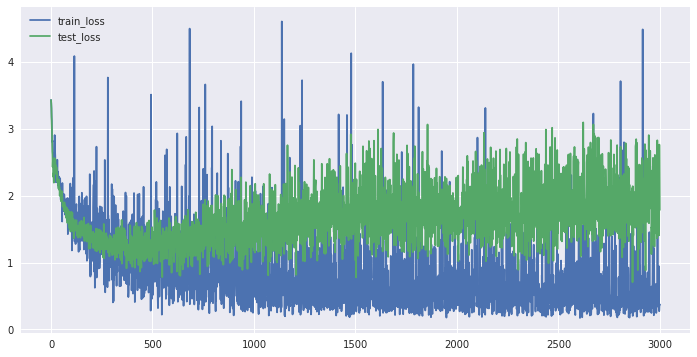

In [57]:
df=pd.DataFrame({"train_loss":trainingloss["loss"],"test_loss":testloss["loss"]})
df[["train_loss","test_loss"]].plot(figsize=(12,6))

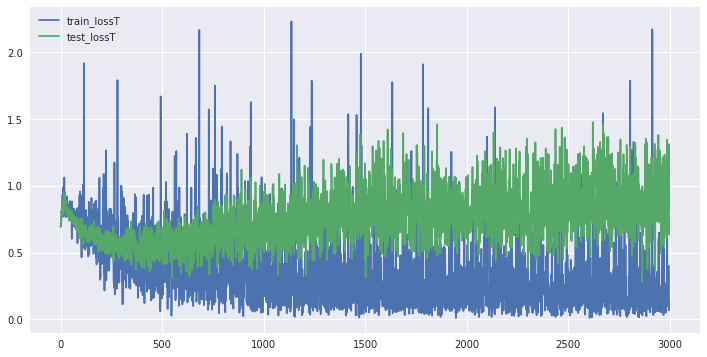

In [58]:
df=pd.DataFrame({"train_lossT":trainingloss["lossT"],"test_lossT":testloss["lossT"]})
df[["train_lossT","test_lossT"]].plot(figsize=(12,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe96fa83710>,
      dtype=object)

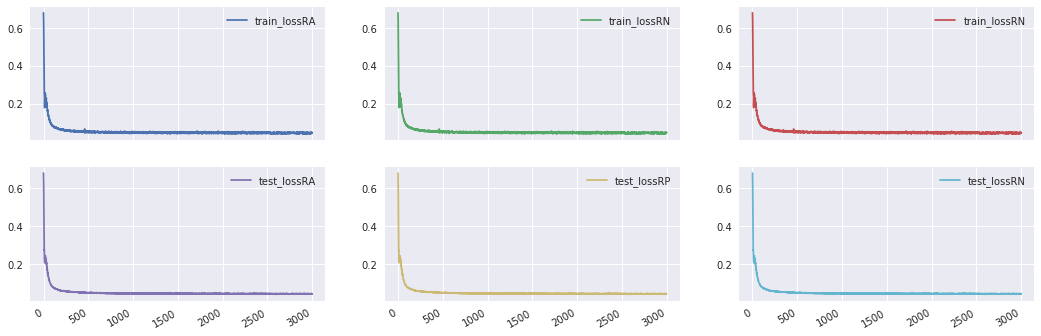

In [59]:
# df=pd.DataFrame(trainingloss)
df=pd.DataFrame({"train_lossRA":trainingloss["lossRA"],"test_lossRA":testloss["lossRA"],
                "train_lossRP":trainingloss["lossRP"],"test_lossRP":testloss["lossRP"],
                 "train_lossRN":trainingloss["lossRN"],"test_lossRN":testloss["lossRN"],
                })
# df[["train_lossT","test_lossT"]].plot(figsize=(12,6))
df[["train_lossRA","train_lossRN","train_lossRN","test_lossRA","test_lossRP","test_lossRN"]].plot(subplots=True,
                                                                                                   figsize=(18,6),layout=(2,3))

## Save model

In [63]:
EncoderStat="EncoderState.pt"
DecoderStat="DecoderState.pt"
torch.save(modelEncoder.state_dict(),EncoderStat) 
torch.save(modelDecoder.state_dict(),DecoderStat) 

In [72]:
trainingloss={k:trainingloss[k]  for k in trainingloss  if len(trainingloss[k])!=0 }
testloss={k:testloss[k]  for k in testloss  if len(testloss[k])!=0 }

## Save DATA

In [73]:
dfTrain=pd.DataFrame(trainingloss)
dfTest=pd.DataFrame(testloss)

In [74]:
trainLossPath="TrainLoss.p"
testLossPath="TestLoss.p"
dfTrain.to_pickle(trainLossPath)
dfTest.to_pickle(testLossPath)